In [9]:
# -*- coding: utf-8 -*-
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, label_binarize
import numpy as np
import torch.backends.cudnn as cudnn
from datetime import datetime
import matplotlib.pyplot as plt  # NEW: for line charts

# Global settings / reproducibility
cudnn.benchmark = True
torch.cuda.empty_cache()
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Root path to UCRArchive_2018
ROOT = r"D:\2025暑期科研\UCRArchive_2018\UCRArchive_2018"

In [10]:
def clean_and_pad_timeseries(raw_2d, min_len=8, cap_len=None, pad_value=0.0,
                             per_sample_standardize=True, fixed_len=None):
    """
    Clean time series with tail NaNs, z-score per-sample (optional), and pad/clip.

    Priority of output length:
      1) fixed_len: if not None, output length = fixed_len (force)
      2) cap_len:   if not None, output length = min(max_real_len, cap_len)
      3) otherwise, output length = max_real_len of this input batch
    """
    import numpy as np

    N, T = raw_2d.shape
    rows, keep_idx, real_lens = [], [], []

    for i in range(N):
        row = raw_2d[i]
        valid_vals = row[~np.isnan(row)]
        L = valid_vals.shape[0]
        if L < min_len:
            continue
        if per_sample_standardize:
            mu = valid_vals.mean()
            sigma = valid_vals.std()
            valid_vals = (valid_vals - mu) / (sigma if sigma > 0 else 1.0)
        rows.append(valid_vals); keep_idx.append(i); real_lens.append(L)

    if len(rows) == 0:
        raise ValueError("All samples filtered out. Lower min_len if needed.")

    max_real_len = max(real_lens)
    if fixed_len is not None:
        target_len = int(fixed_len)
    elif cap_len is not None:
        target_len = min(max_real_len, cap_len)
    else:
        target_len = max_real_len

    out = []
    for arr in rows:
        if arr.shape[0] >= target_len:
            arr = arr[:target_len]
        else:
            arr = np.pad(arr, (0, target_len - arr.shape[0]), constant_values=pad_value)
        out.append(arr)

    X = np.stack(out, axis=0).astype("float32")
    return X, np.array(keep_idx, dtype=np.int64), np.array(real_lens, dtype=np.int64)

In [11]:
class TwoTowerTransformer(nn.Module):
    """
    Two-tower Transformer:
      - Tower 1: time series tokens [B, T, 1] -> embed -> transformer
      - Tower 2: Aout vector [B, F] as a single token -> embed -> transformer
      - Concat tokens -> final transformer -> flatten -> FC for multi-class logits
    """
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3,
                 num_heads, num_layers, num_classes,
                 seq_len1, seq_len2):
        super().__init__()
        # To keep it simple we force equal hidden dims and divisibility by nhead
        assert hidden_dim1 == hidden_dim2 == hidden_dim3, "hidden dims must be equal in this version."
        for h in (hidden_dim1, hidden_dim2, hidden_dim3):
            assert h % num_heads == 0, "hidden_dim must be divisible by num_heads"

        self.embedding1 = nn.Linear(input_dim1, hidden_dim1)
        self.embedding2 = nn.Linear(input_dim2, hidden_dim2)
        self.relu = nn.ReLU()

        self.transformer1 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim1, nhead=num_heads, batch_first=True),
            num_layers=num_layers)

        self.transformer2 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim2, nhead=num_heads, batch_first=True),
            num_layers=num_layers)

        self.final_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim3, nhead=num_heads, batch_first=True),
            num_layers=num_layers)

        self.dropout = nn.Dropout(0.3)
        self.seq_len1 = seq_len1
        self.seq_len2 = 1  # treat Aout as a single token
        fc_in = hidden_dim3 * (seq_len1 + self.seq_len2)
        self.fc = nn.Linear(fc_in, num_classes)

    def forward(self, x1, x2):
        # x1: [B, T, input_dim1], x2: [B, F] or [B, 1, F]
        if x1.dim() == 2:
            x1 = x1.unsqueeze(-1)
        x1 = self.relu(self.embedding1(x1))
        x1 = self.transformer1(x1)

        if x2.dim() == 3:
            assert x2.size(1) == 1, "Expect x2 with L2=1 if 3D"
            x2 = x2.squeeze(1)
        x2 = self.relu(self.embedding2(x2))
        x2 = x2.unsqueeze(1)
        x2 = self.transformer2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = self.final_transformer(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


class VisitDataset(Dataset):
    """Simple tensor dataset for (visit time series, aout features, one-hot labels)."""
    def __init__(self, visit_x, aout_x, y):
        self.visit_x = visit_x.astype("float32")
        self.aout_x  = aout_x.astype("float32")
        self.y       = y.astype("float32")
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.visit_x[idx], self.aout_x[idx], self.y[idx]

In [12]:
# ===== Backbones: Informer / FEDformer (Encoder-only Classifiers) =====
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, seq_len: int, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, seq_len, d_model))
        nn.init.trunc_normal_(self.pe, std=0.02)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1), :])

class TokenEmbedding(nn.Module):
    def __init__(self, input_dim: int, d_model: int):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
    def forward(self, x):  # x: [B, L, C]
        return self.proj(x)

class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=512, dropout=0.1, attn_dropout=0.1, activation='gelu'):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=attn_dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU() if activation.lower()=='gelu' else nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x, attn_mask=None, key_padding_mask=None):
        attn_out, _ = self.self_attn(x, x, x, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=False)
        x = self.norm1(x + self.dropout1(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_out))
        return x

class DistilConv1D(nn.Module):
    def __init__(self, d_model, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=3, stride=2, padding=1)
        self.norm = nn.BatchNorm1d(d_model)
        self.act = nn.ELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):  # [B, L, D]
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.drop(x)
        return x.transpose(1, 2)

class InformerEncoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, e_layers=2, d_ff=512, dropout=0.1, distil=True, attn_dropout=0.1, activation='gelu'):
        super().__init__()
        self.layers = nn.ModuleList([
            InformerEncoderLayer(d_model, n_heads, d_ff, dropout, attn_dropout, activation)
            for _ in range(e_layers)
        ])
        self.distil_layers = nn.ModuleList([DistilConv1D(d_model, dropout=dropout) for _ in range(e_layers-1)]) if distil and e_layers>1 else None
    def forward(self, x):  # [B, L, D]
        if self.distil_layers is None:
            for enc in self.layers: x = enc(x)
            return x
        for i,enc in enumerate(self.layers):
            x = enc(x)
            if i < len(self.layers)-1: x = self.distil_layers[i](x)
        return x

class FourierBlock(nn.Module):
    def __init__(self, k_ratio=0.25):
        super().__init__()
        self.k_ratio = k_ratio
    def forward(self, x):  # [B, L, D]
        B,L,D = x.shape
        Xf = torch.fft.rfft(x, dim=1)
        k = max(1, int((L//2 + 1) * self.k_ratio))
        Xf[:, k:, :] = 0
        return torch.fft.irfft(Xf, n=L, dim=1)

class FEDEncoderLayer(nn.Module):
    def __init__(self, d_model=256, d_ff=512, dropout=0.1, activation='gelu', k_ratio=0.25):
        super().__init__()
        self.fourier = FourierBlock(k_ratio=k_ratio)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU() if activation.lower()=='gelu' else nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x):
        z = self.fourier(x)
        x = self.norm1(x + self.dropout1(z))
        z2 = self.ff(x)
        x = self.norm2(x + self.dropout2(z2))
        return x

class FEDformerEncoder(nn.Module):
    def __init__(self, d_model=256, e_layers=2, d_ff=512, dropout=0.1, activation='gelu', k_ratio=0.25):
        super().__init__()
        self.layers = nn.ModuleList([FEDEncoderLayer(d_model, d_ff, dropout, activation, k_ratio) for _ in range(e_layers)])
    def forward(self, x):
        for enc in self.layers: x = enc(x)
        return x

class TimePoolClassifierHead(nn.Module):
    def __init__(self, d_model: int, num_classes: int, pool: str = "mean", dropout: float = 0.1):
        super().__init__()
        assert pool in ("mean","max","cls")
        self.pool = pool
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
        self.cls_token = nn.Parameter(torch.zeros(1,1,d_model)) if pool=="cls" else None
        if self.cls_token is not None: nn.init.trunc_normal_(self.cls_token, std=0.02)
    def forward(self, x):  # [B, L, D]
        if self.pool=="mean":
            h = x.mean(dim=1)
        elif self.pool=="max":
            h,_ = x.max(dim=1)
        else:
            h = x[:,0,:]
        h = self.dropout(h)
        return self.fc(h)

class InformerEncoderClassifier(nn.Module):
    """Drop-in 替换 TwoTower；forward(x1,x2) 忽略 x2；x1=[B,L,1]"""
    def __init__(self, input_dim:int, num_classes:int, seq_len:int,
                 d_model=256, n_heads=4, e_layers=2, d_ff=512,
                 dropout=0.1, attn_dropout=0.1, distil=True, activation='gelu', pool="mean"):
        super().__init__()
        self.token = TokenEmbedding(input_dim, d_model)
        self.pos = LearnedPositionalEncoding(seq_len, d_model, dropout)
        self.encoder = InformerEncoder(d_model, n_heads, e_layers, d_ff, dropout, distil, attn_dropout, activation)
        self.head = TimePoolClassifierHead(d_model, num_classes, pool, dropout)
    def forward(self, x1, x2=None):
        if x1.dim()==2: x1 = x1.unsqueeze(-1)
        x = self.token(x1); x = self.pos(x); x = self.encoder(x)
        return self.head(x)

class FEDformerEncoderClassifier(nn.Module):
    """Drop-in 替换 TwoTower；forward(x1,x2) 忽略 x2；x1=[B,L,1]"""
    def __init__(self, input_dim:int, num_classes:int, seq_len:int,
                 d_model=256, e_layers=2, d_ff=512, dropout=0.1, activation='gelu', k_ratio=0.25, pool="mean"):
        super().__init__()
        self.token = TokenEmbedding(input_dim, d_model)
        self.pos = LearnedPositionalEncoding(seq_len, d_model, dropout)
        self.encoder = FEDformerEncoder(d_model, e_layers, d_ff, dropout, activation, k_ratio)
        self.head = TimePoolClassifierHead(d_model, num_classes, pool, dropout)
    def forward(self, x1, x2=None):
        if x1.dim()==2: x1 = x1.unsqueeze(-1)
        x = self.token(x1); x = self.pos(x); x = self.encoder(x)
        return self.head(x)


In [13]:
def run_one_dataset(dataset_dir, dataset_name,
                    device='cuda:0',
                    batch_size=8, num_epochs=100, lr=1e-4,
                    cap_len=None, patience=15,
                    verbose=False, plot_curves=True,
                    backbone='twotower'):   # <-- 新增：选择骨干
    import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
    import torch, torch.nn as nn, torch.optim as optim
    from torch.utils.data import DataLoader
    from torch.optim.lr_scheduler import CosineAnnealingLR
    from sklearn.preprocessing import StandardScaler, label_binarize
    from sklearn.metrics import accuracy_score, roc_auc_score

    # --- 读取官方 Train/Test（左塔 TSV + 右塔 CSV） ---
    tsv_train_path = os.path.join(dataset_dir, f"{dataset_name}_TRAIN_cleaned.tsv")
    tsv_test_path  = os.path.join(dataset_dir, f"{dataset_name}_TEST_cleaned.tsv")
    aout_train_csv = os.path.join(dataset_dir, f"{dataset_name}_Aout_train_k2.csv")
    aout_test_csv  = os.path.join(dataset_dir, f"{dataset_name}_Aout_test_k2.csv")
    if not all(os.path.exists(p) for p in [tsv_train_path, tsv_test_path, aout_train_csv, aout_test_csv]):
        print(f"⚠ Skip {dataset_name}, missing files"); return None

    tsv_tr = pd.read_csv(tsv_train_path, sep="\t", header=None)
    tsv_te = pd.read_csv(tsv_test_path,  sep="\t", header=None)
    csv_tr = pd.read_csv(aout_train_csv, header=None)
    csv_te = pd.read_csv(aout_test_csv,  header=None)

    y_tr_raw = tsv_tr.iloc[:,0].values
    y_te_raw = tsv_te.iloc[:,0].values
    visit_tr_raw = tsv_tr.iloc[:,1:].values.astype("float32")
    visit_te_raw = tsv_te.iloc[:,1:].values.astype("float32")
    aout_tr_raw_all  = csv_tr.iloc[:,1:].values.astype("float32")
    aout_te_raw_all  = csv_te.iloc[:,1:].values.astype("float32")

    # --- 先用 Train 得到参考长度 ---
    tmp_train_clean, keep_tr0, _ = clean_and_pad_timeseries(
        visit_tr_raw, min_len=8, cap_len=None, pad_value=0.0, per_sample_standardize=True, fixed_len=None
    )
    train_seq_len = tmp_train_clean.shape[1]

    # --- 固定同长清洗 Train/Test（左塔） ---
    visit_tr_clean, keep_tr, _ = clean_and_pad_timeseries(
        visit_tr_raw, min_len=8, cap_len=None, pad_value=0.0, per_sample_standardize=True, fixed_len=train_seq_len
    )
    y_tr = y_tr_raw[keep_tr]
    aout_tr_raw = aout_tr_raw_all[keep_tr]

    visit_te_clean, keep_te, _ = clean_and_pad_timeseries(
        visit_te_raw, min_len=8, cap_len=None, pad_value=0.0, per_sample_standardize=True, fixed_len=train_seq_len
    )
    y_te = y_te_raw[keep_te]
    aout_te_raw = aout_te_raw_all[keep_te]

    # --- 右塔标准化（仅 TwoTower 需要；但我们仍按原逻辑 fit on Train transform Test） ---
    scaler = StandardScaler().fit(aout_tr_raw)
    aout_tr = scaler.transform(aout_tr_raw).astype("float32")
    aout_te = scaler.transform(aout_te_raw).astype("float32")

    # --- One-hot 标签 ---
    classes = sorted(np.unique(y_tr))
    Y_tr = label_binarize(y_tr, classes=classes).astype("float32")
    Y_te = label_binarize(y_te, classes=classes).astype("float32")

    # --- 左塔输入为 [B, L, 1] ---
    visit_tr = visit_tr_clean[:, :, None]
    visit_te = visit_te_clean[:, :, None]

    # --- 自动参数 ---
    seq_len1 = visit_tr.shape[1]
    input_dim1 = visit_tr.shape[2]
    input_dim2 = aout_tr.shape[1]   # TwoTower 用；单塔忽略
    num_classes = Y_tr.shape[1]

    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # ========== 构建模型（按 backbone 选择） ==========
    if backbone.lower() == 'twotower':
        hidden_dim1 = hidden_dim2 = hidden_dim3 = 16
        num_heads = 2; num_layers = 2; seq_len2 = 1
        model = TwoTowerTransformer(
            input_dim1, input_dim2,
            hidden_dim1, hidden_dim2, hidden_dim3,
            num_heads, num_layers,
            num_classes,
            seq_len1, seq_len2
        ).to(device)
    elif backbone.lower() == 'informer':
        model = InformerEncoderClassifier(
            input_dim=1, num_classes=num_classes, seq_len=seq_len1,
            d_model=256, n_heads=4, e_layers=2, d_ff=512,
            dropout=0.1, attn_dropout=0.1, distil=True, activation='gelu', pool='mean'
        ).to(device)
    elif backbone.lower() in ('fed', 'fedformer'):
        model = FEDformerEncoderClassifier(
            input_dim=1, num_classes=num_classes, seq_len=seq_len1,
            d_model=256, e_layers=2, d_ff=512,
            dropout=0.1, activation='gelu', k_ratio=0.25, pool='mean'
        ).to(device)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")

    # 多卡封装（与原逻辑一致）
    if torch.cuda.device_count() > 1 and str(device).startswith('cuda'):
        model = nn.DataParallel(model, device_ids=[0,1])
    model = model.to(device)

    # --- DataLoader（保持你原来三元组，单塔会忽略 aout） ---
    train_loader = DataLoader(VisitDataset(visit_tr, aout_tr, Y_tr), batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
    test_loader  = DataLoader(VisitDataset(visit_te, aout_te, Y_te), batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

    # --- 优化器/损失/调度器（不变） ---
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

    # --- 仅基于 TrainLoss 的 EarlyStopping（不看 Test） ---
    class EarlyStopping:
        def __init__(self, patience=15, delta=0.0):
            self.patience = patience; self.delta = delta
            self.counter = 0; self.best = None; self.stop = False
        def step(self, train_loss):
            if self.best is None: self.best = train_loss; return False
            if train_loss > self.best - self.delta:
                self.counter += 1
                if self.counter >= self.patience: self.stop = True
            else:
                self.best = train_loss; self.counter = 0
            return self.stop
    es = EarlyStopping(patience=patience)

    # --- 训练（只记录 TrainLoss；不跑 Test） ---
    log_dir = os.path.join(dataset_dir, "_twotower_logs"); os.makedirs(log_dir, exist_ok=True)
    log_file = open(os.path.join(log_dir, f"log_{backbone}.txt"), "w", encoding="utf-8")
    train_loss_hist = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for x1,x2,y in train_loader:
            x1 = x1.to(torch.float32).to(device)
            x2 = x2.to(torch.float32).to(device)
            y  = y.to(torch.float32).to(device)
            optimizer.zero_grad()
            o = model(x1,x2)   # 单塔会忽略 x2
            l = criterion(o,y)
            l.backward(); optimizer.step()
            total_loss += l.item()
        scheduler.step()
        avg_train_loss = total_loss / max(1,len(train_loader))
        train_loss_hist.append(avg_train_loss)
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}\n")
        if es.step(avg_train_loss): break
    log_file.close()

    # --- 画 TrainLoss ---
    if plot_curves and len(train_loss_hist)>0:
        import matplotlib.pyplot as plt
        fig,ax=plt.subplots(figsize=(6,4))
        ax.plot(range(1,len(train_loss_hist)+1), train_loss_hist, label="Train Loss")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Loss"); ax.grid(True); ax.legend()
        ax.set_title(f"{dataset_name} - {backbone} - Train Loss")
        plt.tight_layout(); plt.savefig(os.path.join(log_dir, f"{dataset_name}_{backbone}_train_loss.png"), dpi=150); plt.show()

    # --- 最终 Test 评估（一次性） ---
    model.eval()
    tout=[]; tlab=[]
    with torch.no_grad():
        for x1,x2,y in test_loader:
            x1 = x1.to(torch.float32).to(device)
            x2 = x2.to(torch.float32).to(device)
            o = model(x1,x2)
            tout.append(o.detach().cpu().numpy()); tlab.append(y.numpy())
    tout = np.concatenate(tout); tlab = np.concatenate(tlab)
    try:  test_auc = roc_auc_score(tlab, tout, multi_class='ovr')
    except: test_auc = roc_auc_score(tlab, tout)
    test_pred = np.argmax(tout, axis=1)
    test_true = np.argmax(tlab, axis=1)
    test_acc = accuracy_score(test_true, test_pred)
    test_n = len(tlab)

    print(f"[{dataset_name} | {backbone}] TEST AUC={test_auc:.4f}, TEST ACC={test_acc:.4f}, n_samples={test_n}")
    return test_auc, test_acc, test_n


In [14]:
def discover_datasets(root):
    """
    Discover dataset subfolders that contain all four required files:
      *_TRAIN_cleaned.tsv, *_TEST_cleaned.tsv, *_Aout_train_k2.csv, *_Aout_test_k2.csv
    Returns: a sorted list of dataset names (folder names).
    """
    names = []
    for name in sorted(os.listdir(root)):
        subdir = os.path.join(root, name)
        if not os.path.isdir(subdir):
            continue
        t_train = os.path.join(subdir, f"{name}_TRAIN_cleaned.tsv")
        t_test  = os.path.join(subdir, f"{name}_TEST_cleaned.tsv")
        a_train = os.path.join(subdir, f"{name}_Aout_train_k2.csv")
        a_test  = os.path.join(subdir, f"{name}_Aout_test_k2.csv")
        if all(os.path.exists(p) for p in [t_train, t_test, a_train, a_test]):
            names.append(name)
    return names

In [15]:
def run_all_datasets(root, device='cuda:0',
                     batch_size=8, num_epochs=100, lr=1e-4,
                     cap_len=None, verbose=False, plot_curves=True,
                     patience=15, backbone='twotower'):
    import os, pandas as pd
    from datetime import datetime

    dataset_names = discover_datasets(root)
    print(f"Found {len(dataset_names)} datasets:", dataset_names)

    rows = []
    for name in dataset_names:
        out = run_one_dataset(
            dataset_dir=os.path.join(root, name),
            dataset_name=name,
            device=device,
            batch_size=batch_size, num_epochs=num_epochs, lr=lr,
            cap_len=cap_len, patience=patience,
            verbose=verbose, plot_curves=plot_curves,
            backbone=backbone   # <-- 透传骨干
        )
        if out is None: continue
        test_auc, test_acc, test_n = out
        rows.append((name, test_auc, test_acc, test_n))

    if not rows:
        print("No dataset finished successfully."); return None

    df = pd.DataFrame(rows, columns=["dataset", "test_auc", "test_acc", "n_samples"])
    mean_auc = df["test_auc"].mean(); mean_acc = df["test_acc"].mean()
    w_auc = (df["test_auc"] * df["n_samples"]).sum() / df["n_samples"].sum()
    w_acc = (df["test_acc"] * df["n_samples"]).sum() / df["n_samples"].sum()

    print("\n========== Summary (OFFICIAL TEST) ==========")
    print(df.sort_values("dataset").to_string(index=False))
    print(f"\nSimple mean: AUC = {mean_auc:.4f}, ACC = {mean_acc:.4f}")
    print(f"Weighted (by samples): AUC = {w_auc:.4f}, ACC = {w_acc:.4f}")

    summary_dir = os.path.join(root, "_twotower_logs"); os.makedirs(summary_dir, exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    tag = backbone.lower()
    df.to_csv(os.path.join(summary_dir, f"summary_TEST_{tag}_{ts}.csv"), index=False, encoding="utf-8")
    with open(os.path.join(summary_dir, f"summary_TEST_{tag}_{ts}.txt"), "w", encoding="utf-8") as f:
        f.write(df.sort_values("dataset").to_string(index=False))
        f.write(f"\n\nSimple mean: AUC={mean_auc:.6f}, ACC={mean_acc:.6f}\n")
        f.write(f"Weighted (by samples): AUC={w_auc:.6f}, ACC={w_acc:.6f}\n")

    return df, (mean_auc, mean_acc), (w_auc, w_acc)


Found 125 datasets: ['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'BME', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF', 'Car', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG200', 'ECG5000', 'ECGFiveDays', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'Earthquakes', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbea

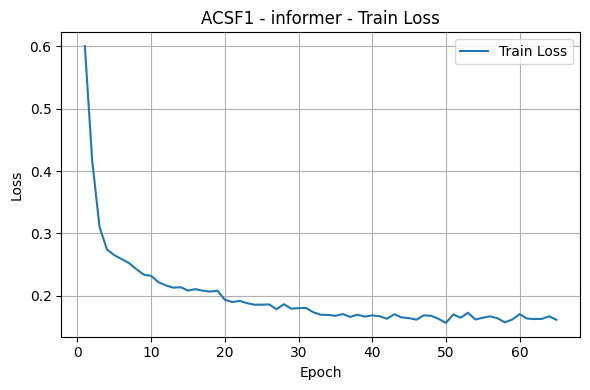

[ACSF1 | informer] TEST AUC=0.9646, TEST ACC=0.7500, n_samples=100


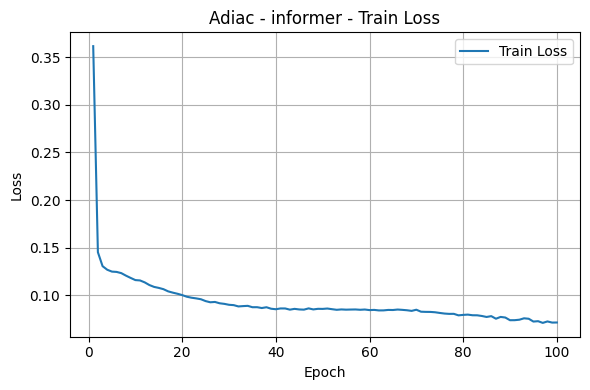

[Adiac | informer] TEST AUC=0.9444, TEST ACC=0.3427, n_samples=391


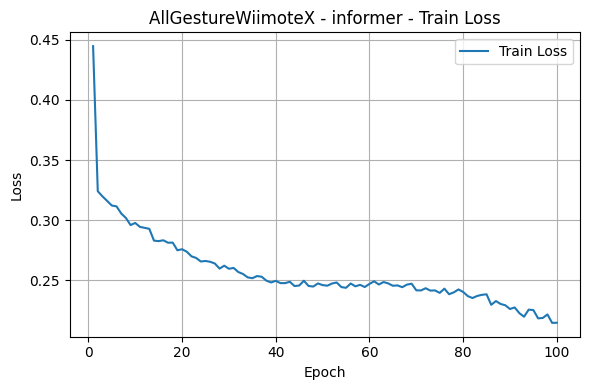

[AllGestureWiimoteX | informer] TEST AUC=0.8238, TEST ACC=0.3656, n_samples=681


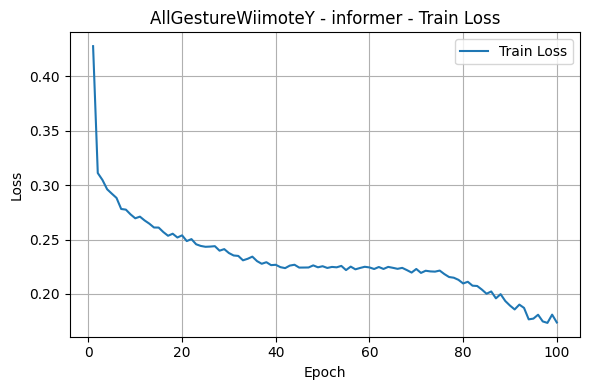

[AllGestureWiimoteY | informer] TEST AUC=0.8730, TEST ACC=0.4775, n_samples=645


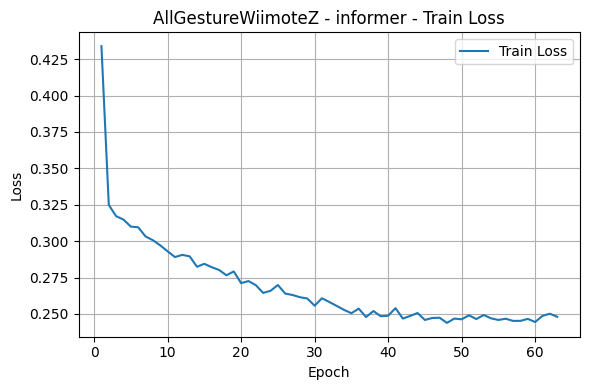

[AllGestureWiimoteZ | informer] TEST AUC=0.7986, TEST ACC=0.3066, n_samples=685


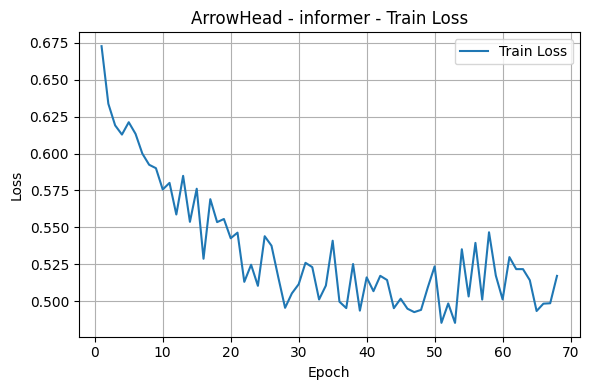

[ArrowHead | informer] TEST AUC=0.7461, TEST ACC=0.5029, n_samples=175


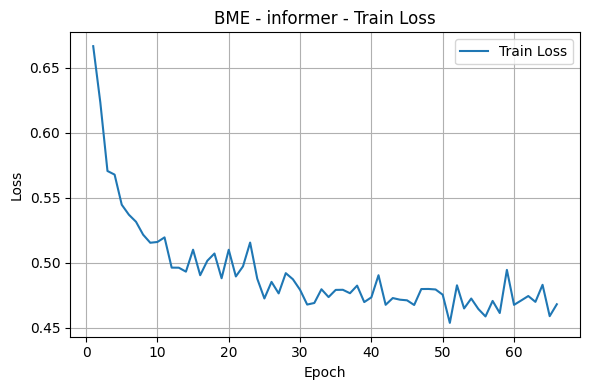

[BME | informer] TEST AUC=0.7794, TEST ACC=0.5667, n_samples=150


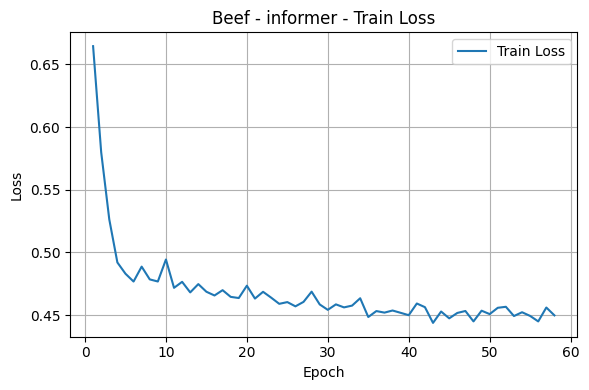

[Beef | informer] TEST AUC=0.7181, TEST ACC=0.4333, n_samples=30


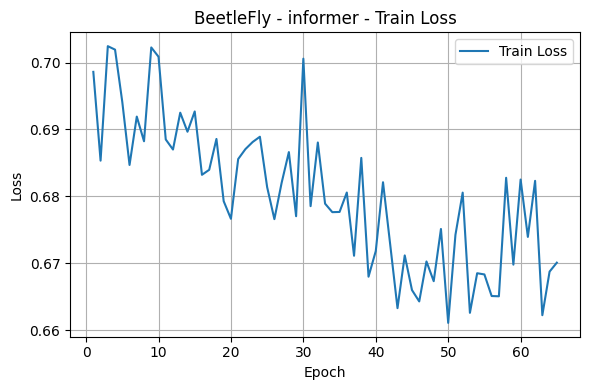

[BeetleFly | informer] TEST AUC=0.7200, TEST ACC=1.0000, n_samples=20


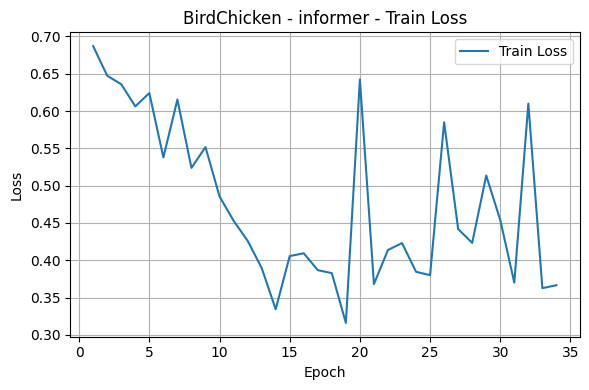

[BirdChicken | informer] TEST AUC=0.9400, TEST ACC=1.0000, n_samples=20


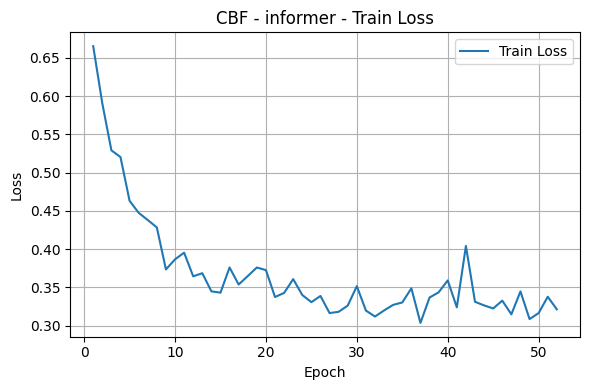

[CBF | informer] TEST AUC=0.8470, TEST ACC=0.6300, n_samples=900


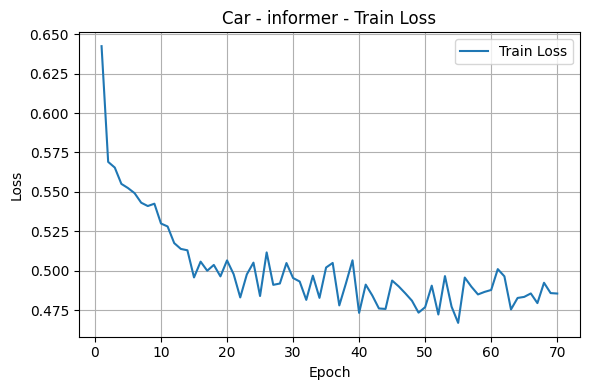

[Car | informer] TEST AUC=0.7907, TEST ACC=0.5333, n_samples=60


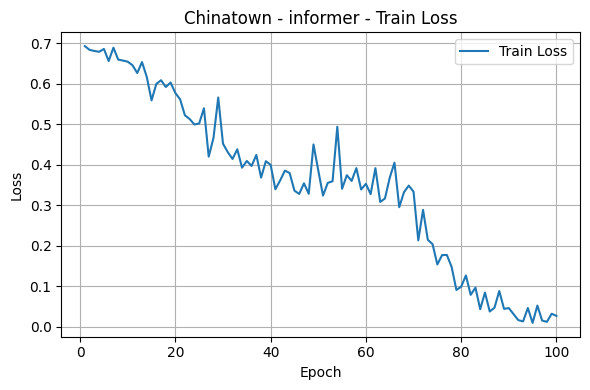

[Chinatown | informer] TEST AUC=0.9929, TEST ACC=1.0000, n_samples=343


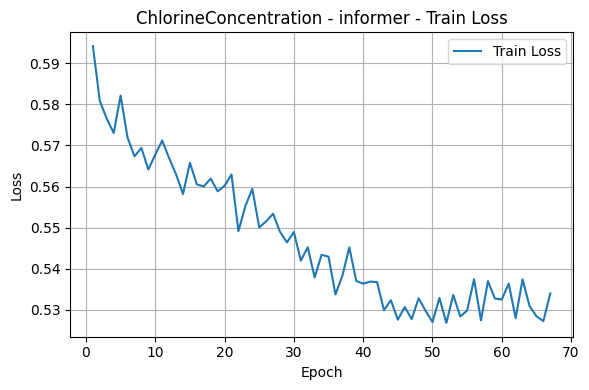

[ChlorineConcentration | informer] TEST AUC=0.6214, TEST ACC=0.5669, n_samples=3840


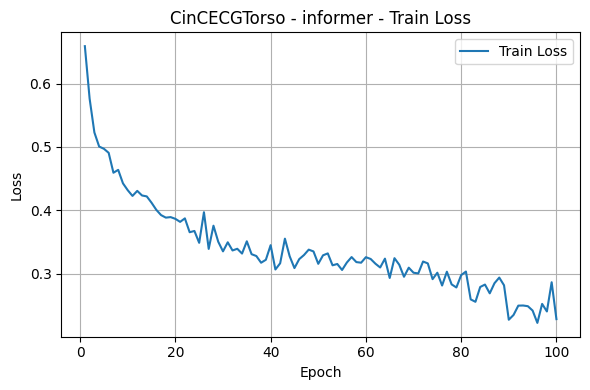

[CinCECGTorso | informer] TEST AUC=0.7828, TEST ACC=0.5623, n_samples=1380


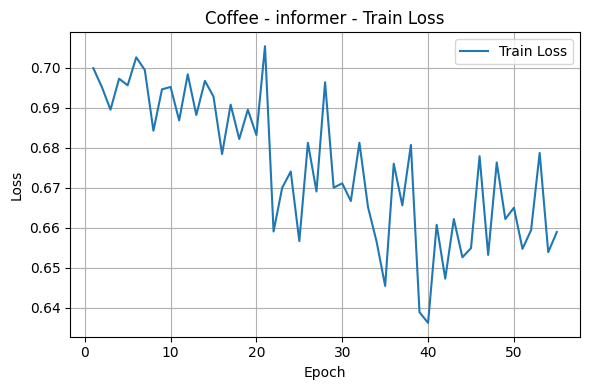

[Coffee | informer] TEST AUC=0.6974, TEST ACC=1.0000, n_samples=28


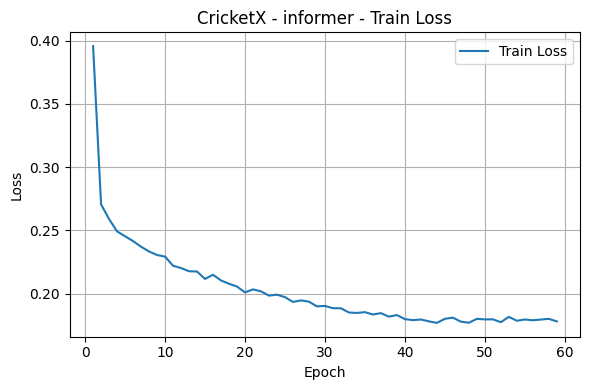

[CricketX | informer] TEST AUC=0.8288, TEST ACC=0.3949, n_samples=390


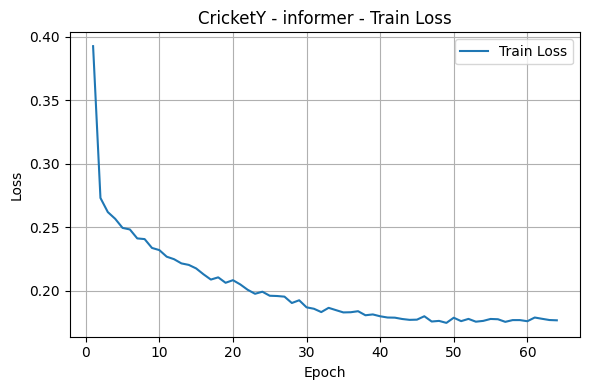

[CricketY | informer] TEST AUC=0.8665, TEST ACC=0.4205, n_samples=390


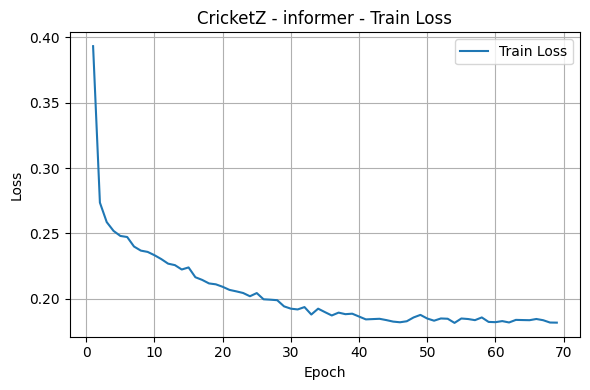

[CricketZ | informer] TEST AUC=0.8452, TEST ACC=0.3872, n_samples=390


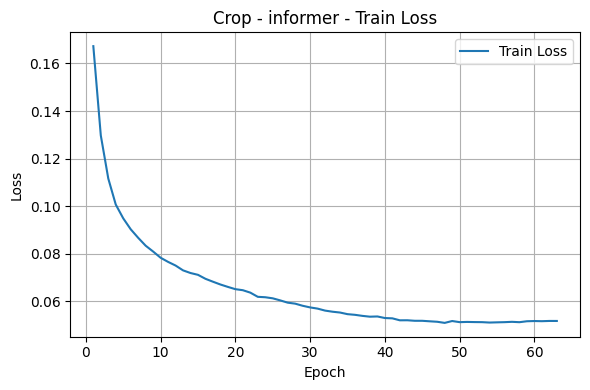

[Crop | informer] TEST AUC=0.9706, TEST ACC=0.6969, n_samples=16778


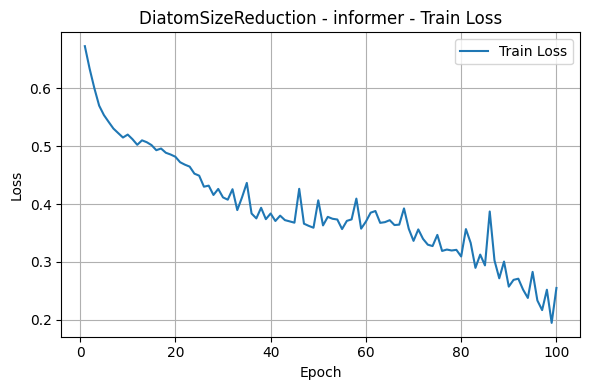

[DiatomSizeReduction | informer] TEST AUC=0.9869, TEST ACC=0.8660, n_samples=306


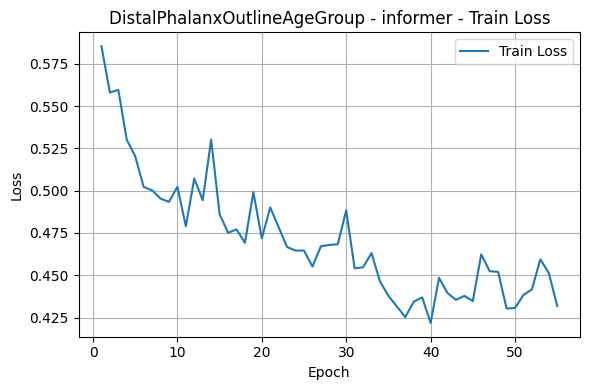

[DistalPhalanxOutlineAgeGroup | informer] TEST AUC=0.7744, TEST ACC=0.6566, n_samples=99


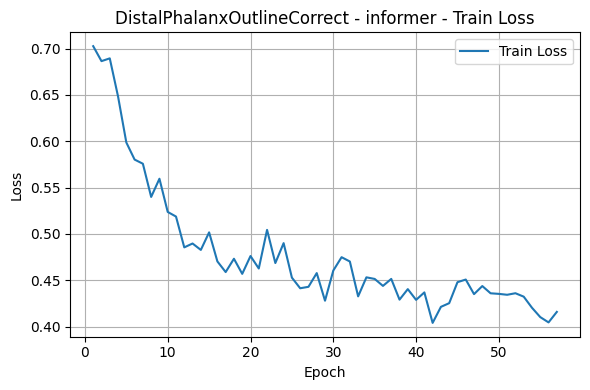

[DistalPhalanxOutlineCorrect | informer] TEST AUC=0.8576, TEST ACC=1.0000, n_samples=199


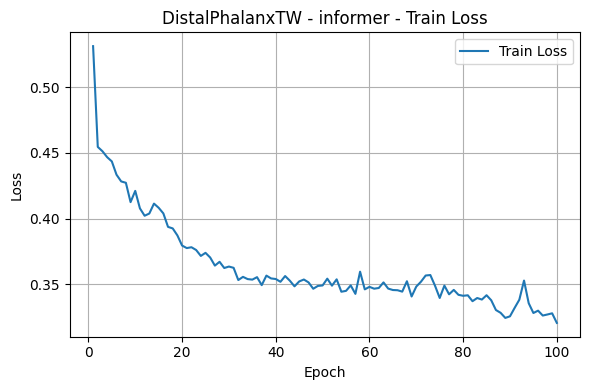

[DistalPhalanxTW | informer] TEST AUC=0.7676, TEST ACC=0.5106, n_samples=94


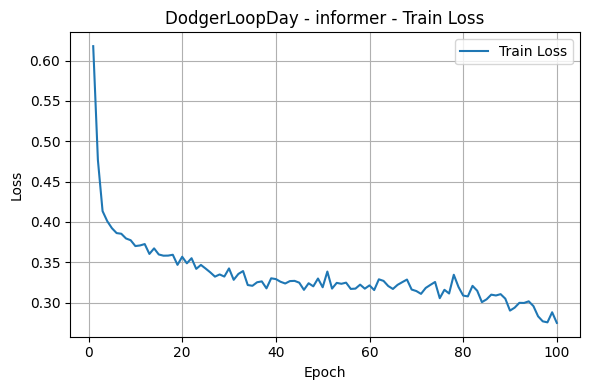

[DodgerLoopDay | informer] TEST AUC=0.8002, TEST ACC=0.4125, n_samples=80


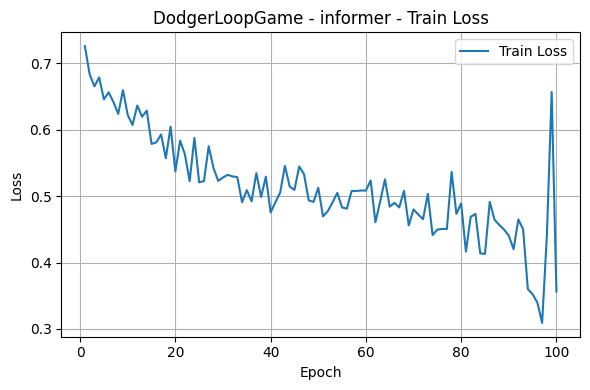

[DodgerLoopGame | informer] TEST AUC=0.8258, TEST ACC=1.0000, n_samples=138


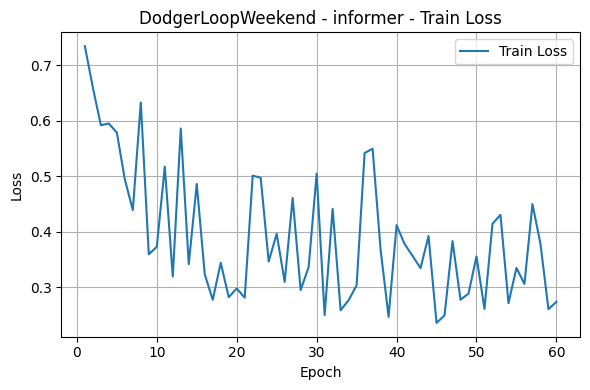

[DodgerLoopWeekend | informer] TEST AUC=0.8932, TEST ACC=1.0000, n_samples=138


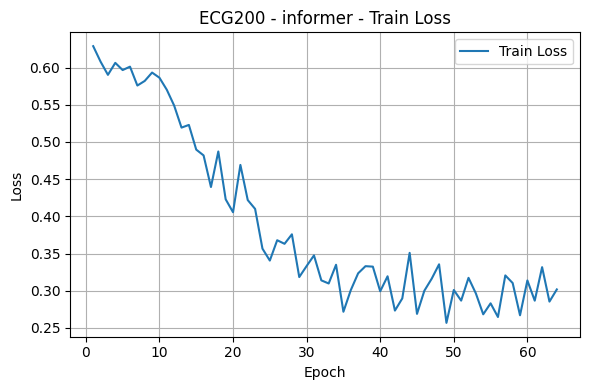

[ECG200 | informer] TEST AUC=0.8424, TEST ACC=1.0000, n_samples=100


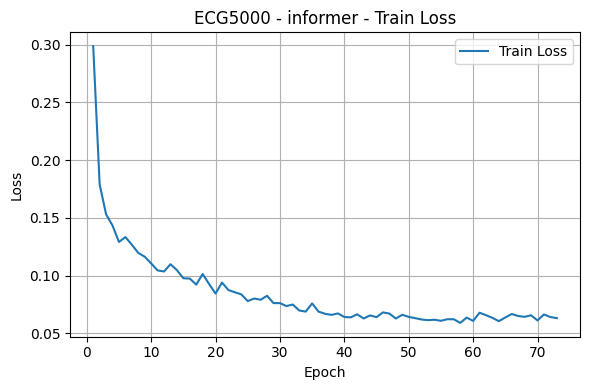

[ECG5000 | informer] TEST AUC=0.8846, TEST ACC=0.9324, n_samples=4500


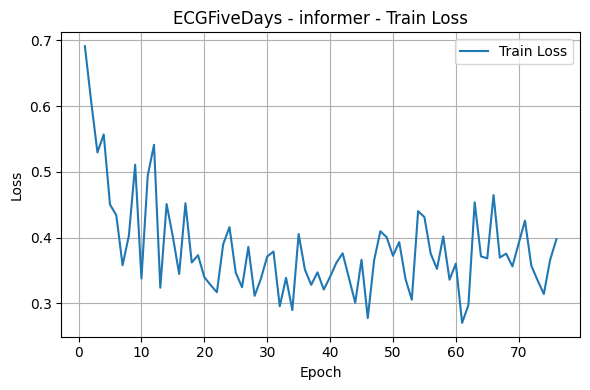

[ECGFiveDays | informer] TEST AUC=0.8235, TEST ACC=1.0000, n_samples=861


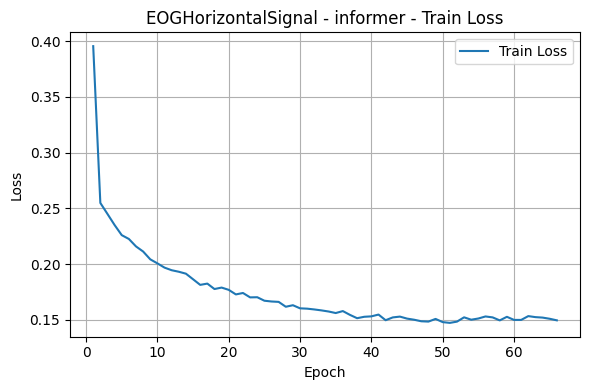

[EOGHorizontalSignal | informer] TEST AUC=0.8362, TEST ACC=0.3729, n_samples=362


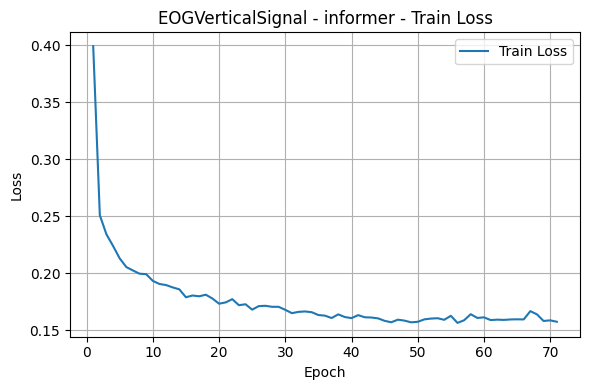

[EOGVerticalSignal | informer] TEST AUC=0.8265, TEST ACC=0.3370, n_samples=362


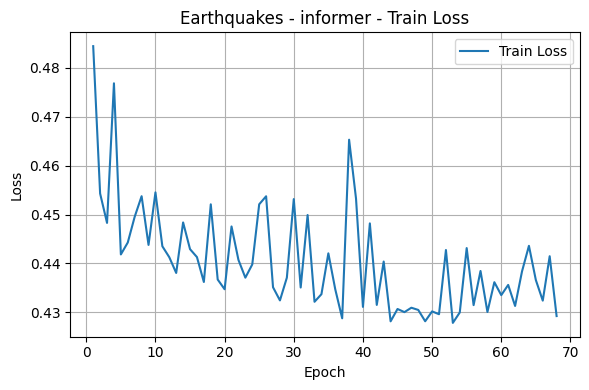

[Earthquakes | informer] TEST AUC=0.6797, TEST ACC=1.0000, n_samples=139


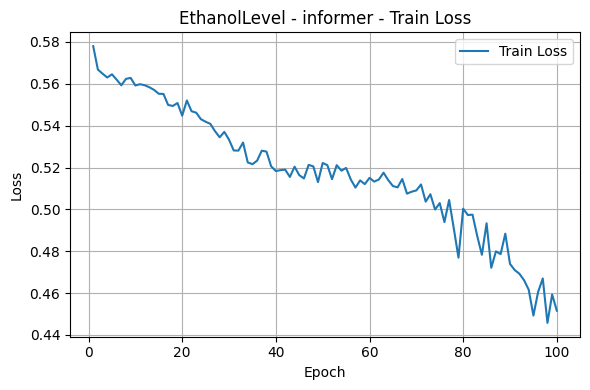

[EthanolLevel | informer] TEST AUC=0.7099, TEST ACC=0.2480, n_samples=500


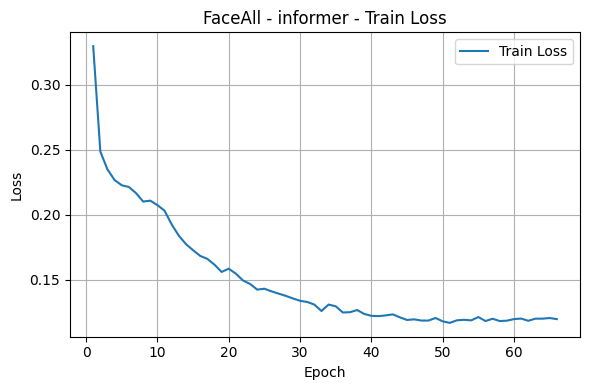

[FaceAll | informer] TEST AUC=0.9340, TEST ACC=0.4976, n_samples=1690


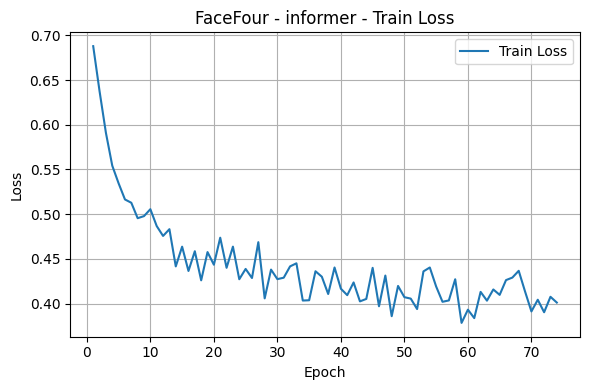

[FaceFour | informer] TEST AUC=0.7067, TEST ACC=0.3580, n_samples=81


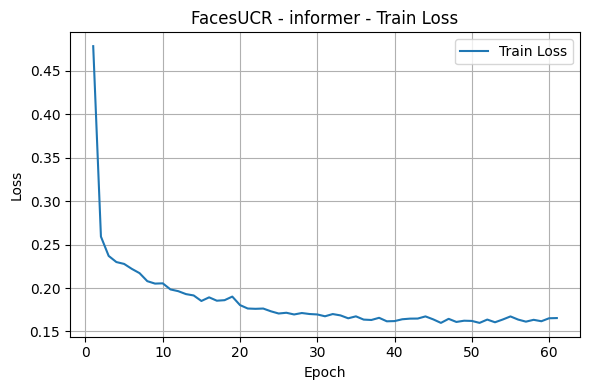

[FacesUCR | informer] TEST AUC=0.8657, TEST ACC=0.4220, n_samples=2050


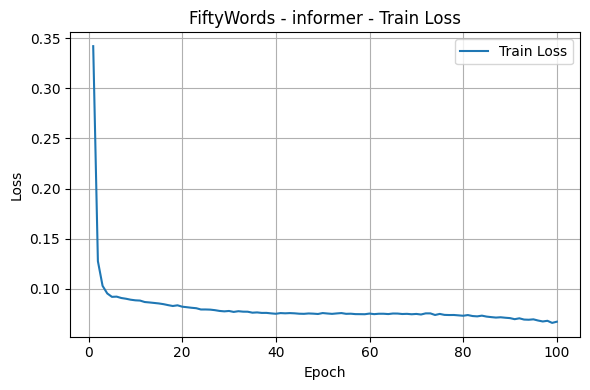

[FiftyWords | informer] TEST AUC=0.8287, TEST ACC=0.2945, n_samples=455


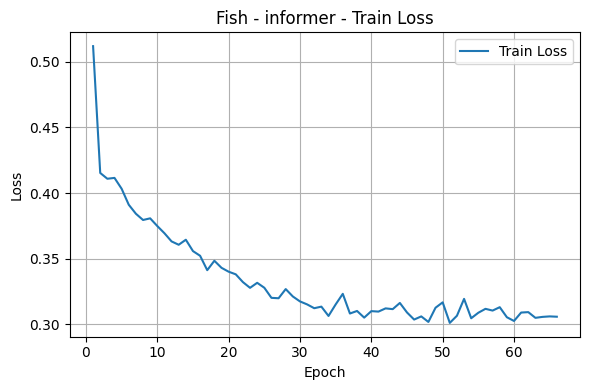

[Fish | informer] TEST AUC=0.8261, TEST ACC=0.4286, n_samples=175


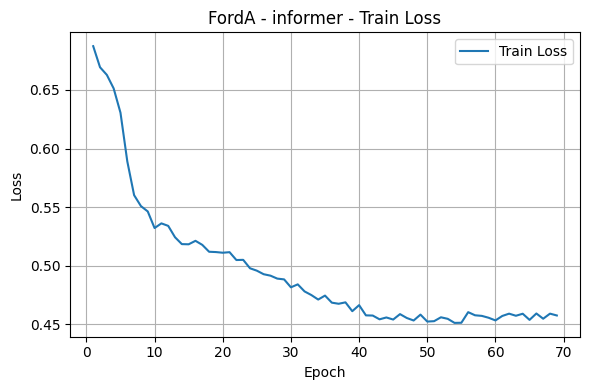

[FordA | informer] TEST AUC=0.8159, TEST ACC=1.0000, n_samples=1320


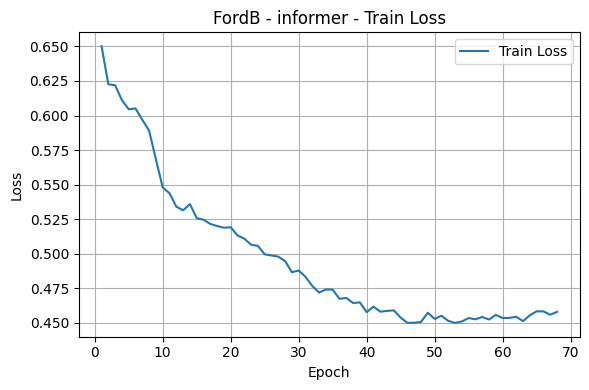

[FordB | informer] TEST AUC=0.6604, TEST ACC=1.0000, n_samples=810


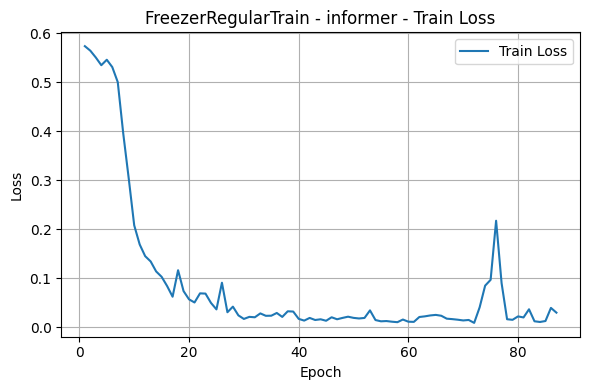

[FreezerRegularTrain | informer] TEST AUC=0.9991, TEST ACC=1.0000, n_samples=2850


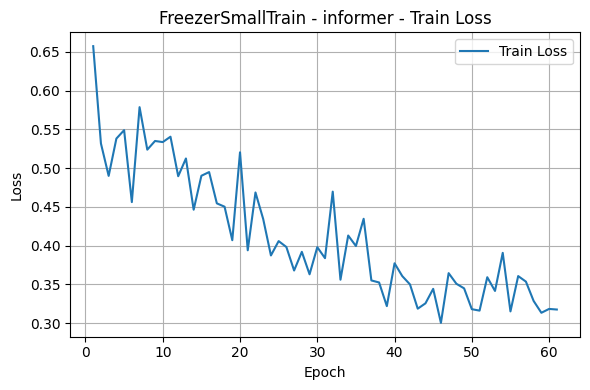

[FreezerSmallTrain | informer] TEST AUC=0.8500, TEST ACC=1.0000, n_samples=2850


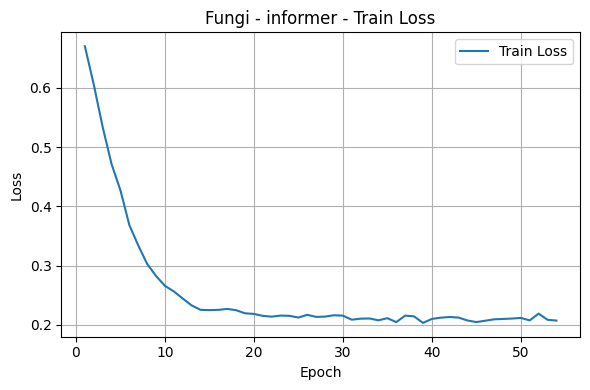

[Fungi | informer] TEST AUC=0.7604, TEST ACC=0.1129, n_samples=186


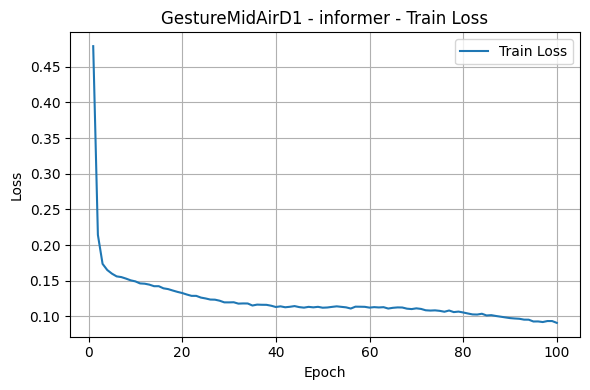

[GestureMidAirD1 | informer] TEST AUC=0.9221, TEST ACC=0.4769, n_samples=130


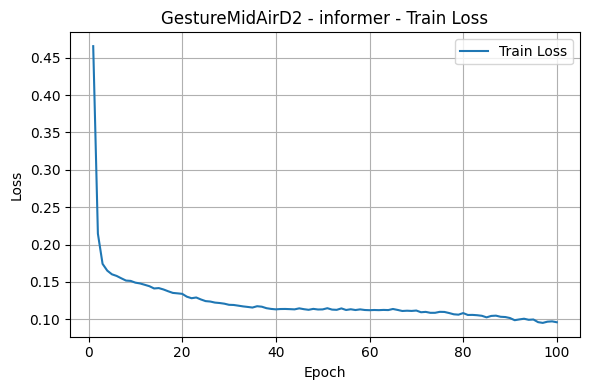

[GestureMidAirD2 | informer] TEST AUC=0.9334, TEST ACC=0.4308, n_samples=130


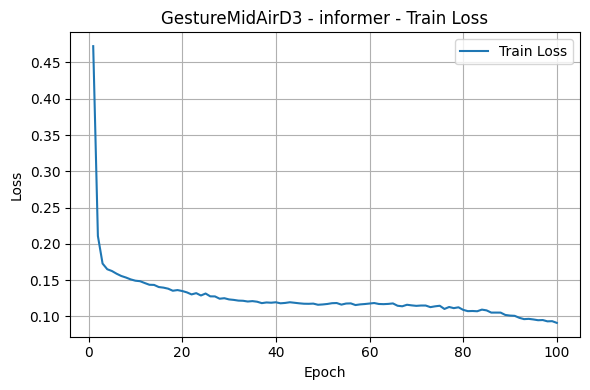

[GestureMidAirD3 | informer] TEST AUC=0.9049, TEST ACC=0.2692, n_samples=130


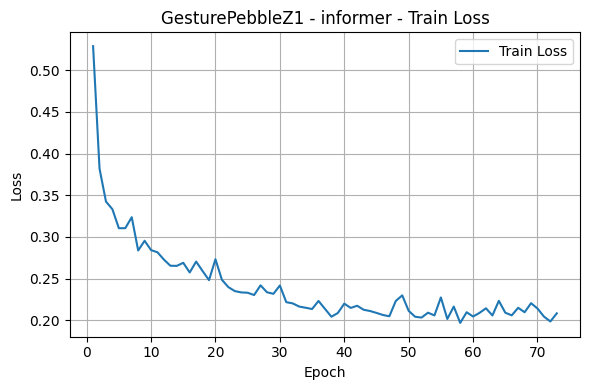

[GesturePebbleZ1 | informer] TEST AUC=0.9344, TEST ACC=0.7151, n_samples=172


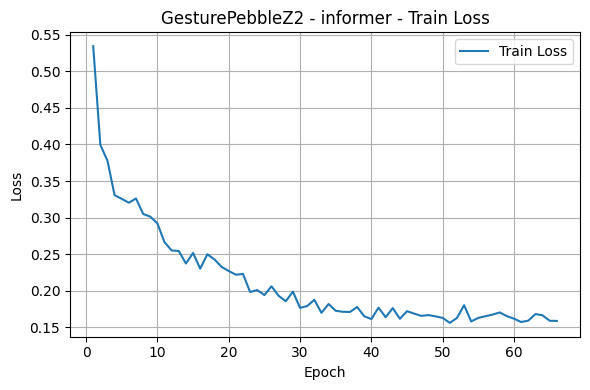

[GesturePebbleZ2 | informer] TEST AUC=0.9253, TEST ACC=0.7405, n_samples=158


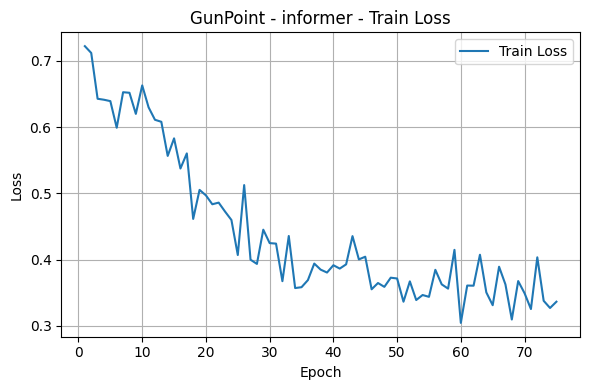

[GunPoint | informer] TEST AUC=0.9522, TEST ACC=1.0000, n_samples=150


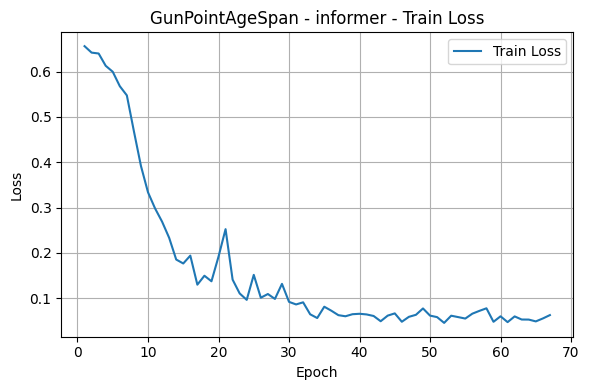

[GunPointAgeSpan | informer] TEST AUC=0.9954, TEST ACC=1.0000, n_samples=316


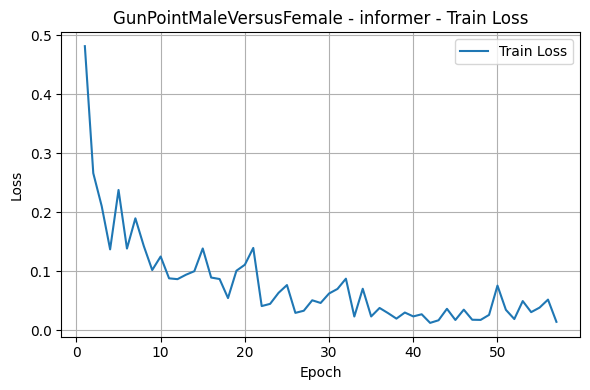

[GunPointMaleVersusFemale | informer] TEST AUC=0.9984, TEST ACC=1.0000, n_samples=316


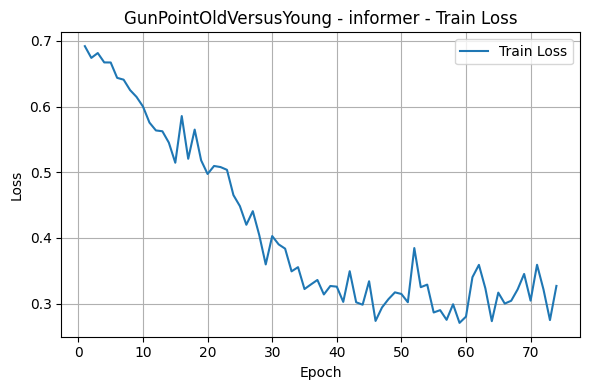

[GunPointOldVersusYoung | informer] TEST AUC=0.9886, TEST ACC=1.0000, n_samples=315


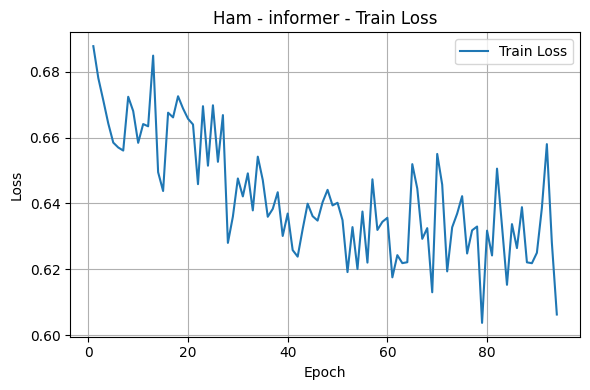

[Ham | informer] TEST AUC=0.6674, TEST ACC=1.0000, n_samples=105


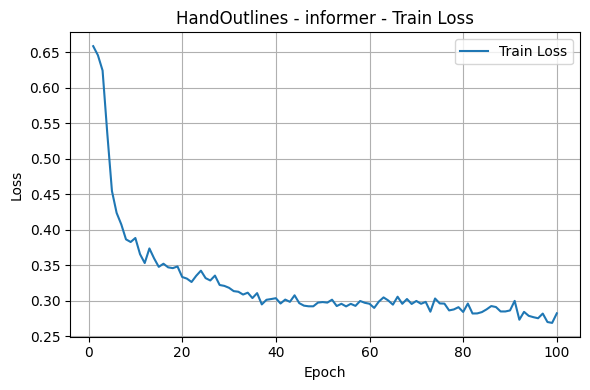

[HandOutlines | informer] TEST AUC=0.9324, TEST ACC=1.0000, n_samples=370


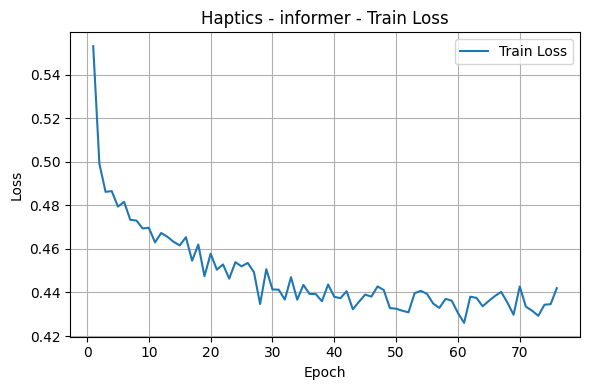

[Haptics | informer] TEST AUC=0.6426, TEST ACC=0.2825, n_samples=308


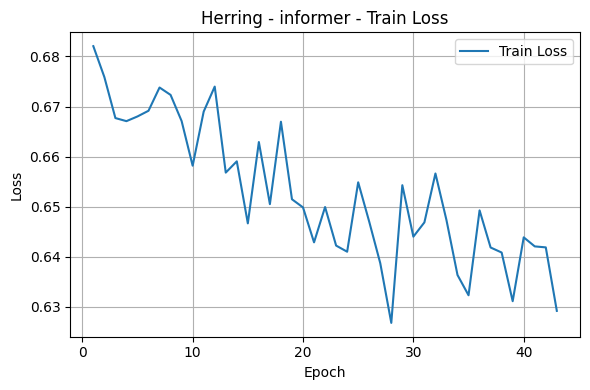

[Herring | informer] TEST AUC=0.4605, TEST ACC=1.0000, n_samples=64


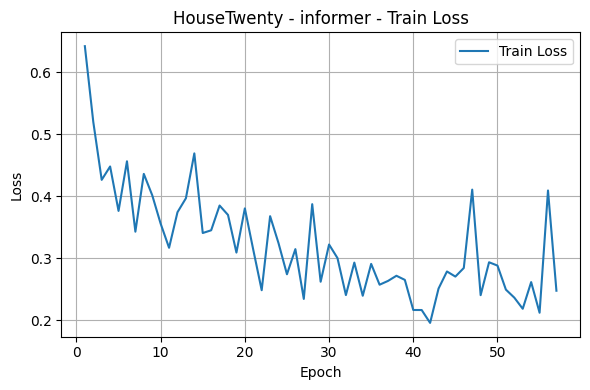

[HouseTwenty | informer] TEST AUC=0.9354, TEST ACC=1.0000, n_samples=119


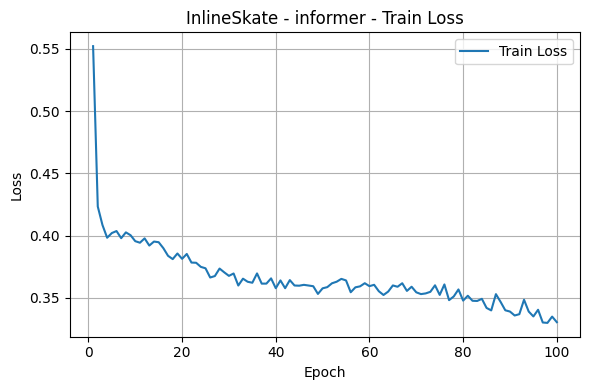

[InlineSkate | informer] TEST AUC=0.6300, TEST ACC=0.2782, n_samples=550


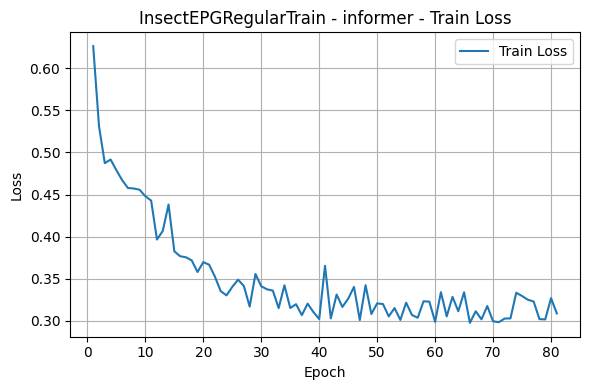

[InsectEPGRegularTrain | informer] TEST AUC=0.8763, TEST ACC=0.7992, n_samples=249


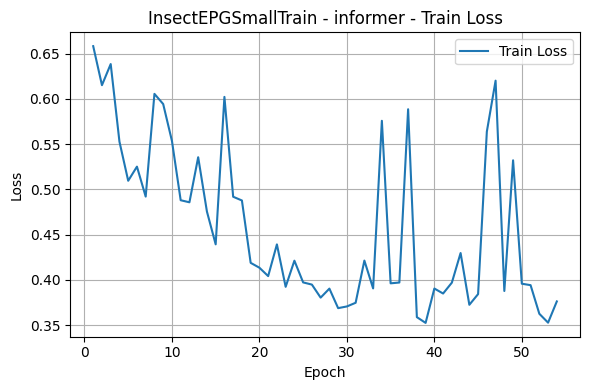

[InsectEPGSmallTrain | informer] TEST AUC=0.8166, TEST ACC=0.7189, n_samples=249


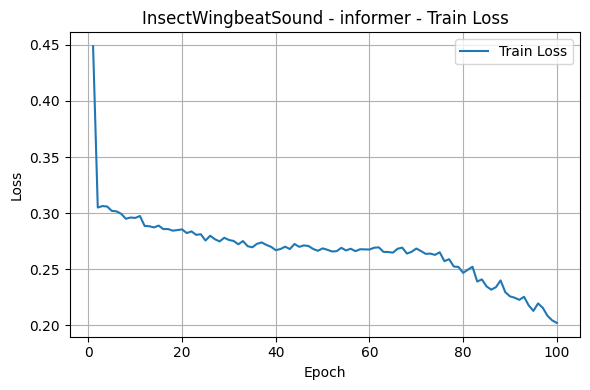

[InsectWingbeatSound | informer] TEST AUC=0.8490, TEST ACC=0.2551, n_samples=1980


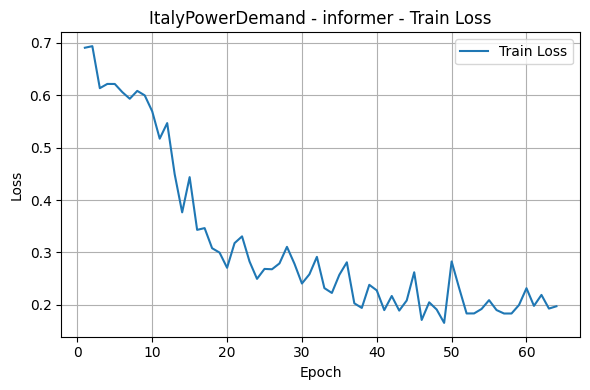

[ItalyPowerDemand | informer] TEST AUC=0.9308, TEST ACC=1.0000, n_samples=1028


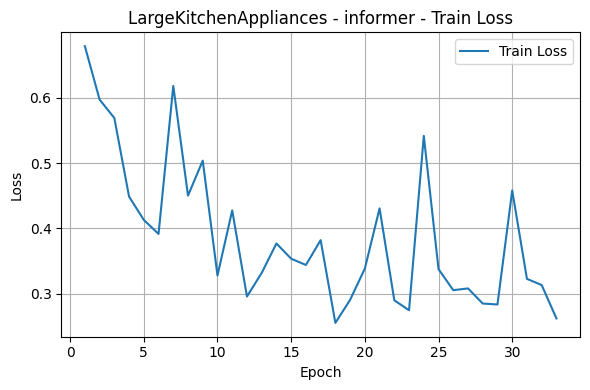

[LargeKitchenAppliances | informer] TEST AUC=0.5286, TEST ACC=0.4118, n_samples=17


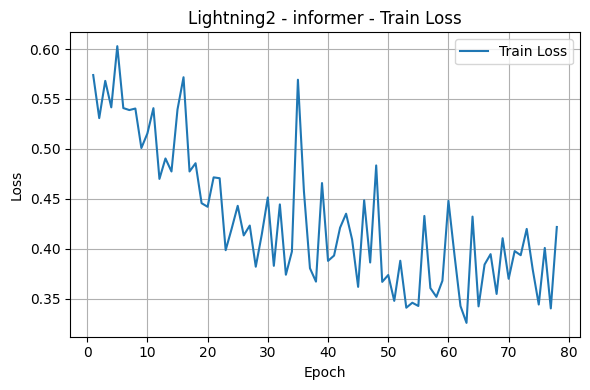

[Lightning2 | informer] TEST AUC=0.8344, TEST ACC=1.0000, n_samples=61


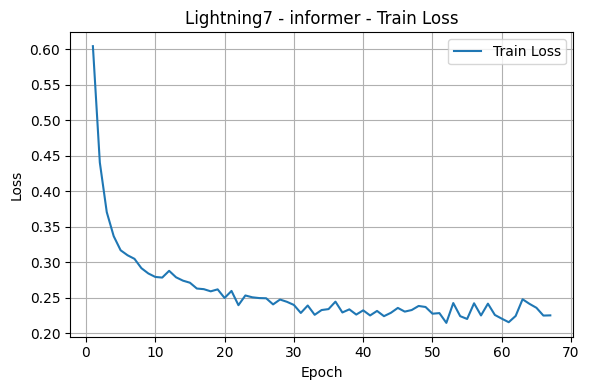

[Lightning7 | informer] TEST AUC=0.8871, TEST ACC=0.5068, n_samples=73


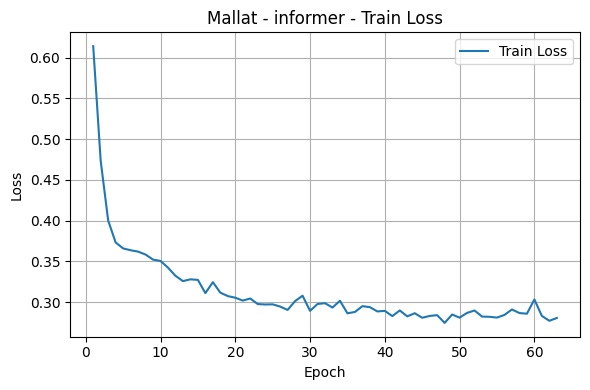

[Mallat | informer] TEST AUC=0.8545, TEST ACC=0.4674, n_samples=2345


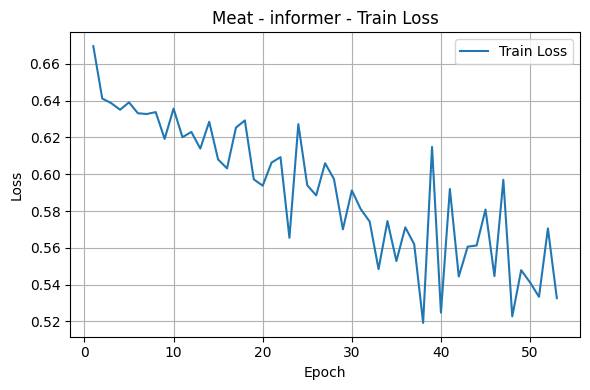

[Meat | informer] TEST AUC=0.8058, TEST ACC=0.3333, n_samples=60


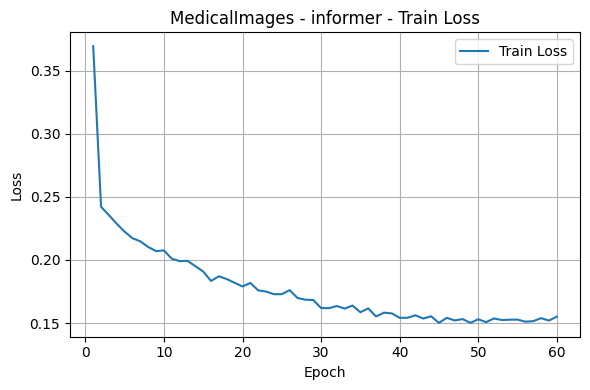

[MedicalImages | informer] TEST AUC=0.8825, TEST ACC=0.6224, n_samples=760


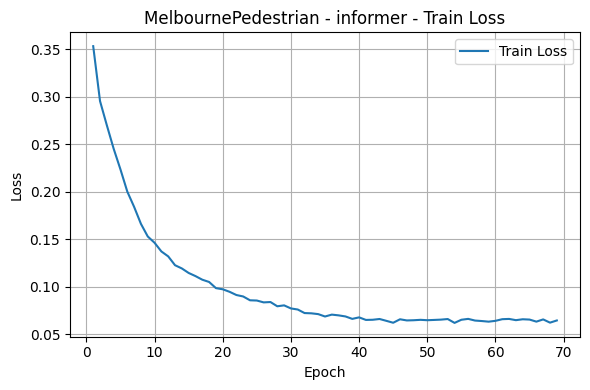

[MelbournePedestrian | informer] TEST AUC=0.9718, TEST ACC=0.8268, n_samples=2425


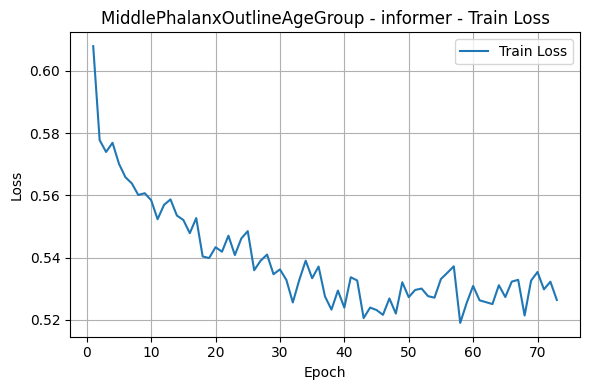

[MiddlePhalanxOutlineAgeGroup | informer] TEST AUC=0.5961, TEST ACC=0.6395, n_samples=147


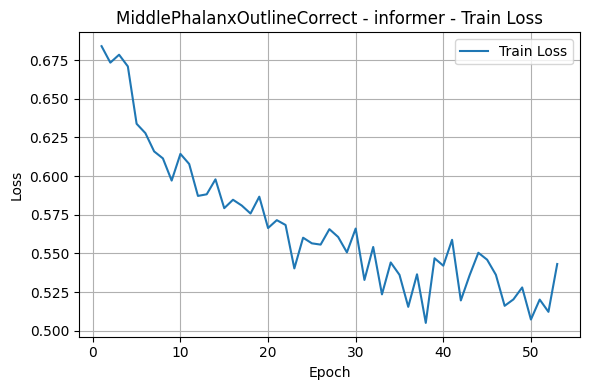

[MiddlePhalanxOutlineCorrect | informer] TEST AUC=0.8735, TEST ACC=1.0000, n_samples=276


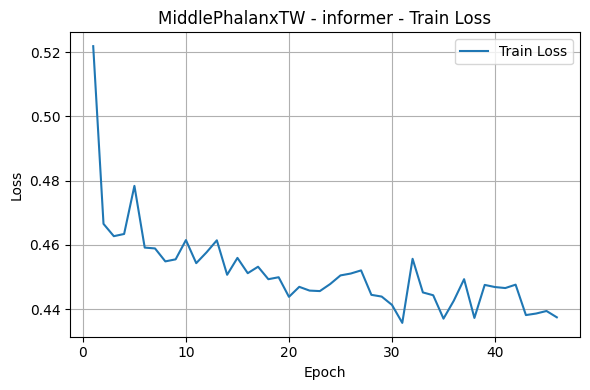

[MiddlePhalanxTW | informer] TEST AUC=0.6471, TEST ACC=0.4000, n_samples=110


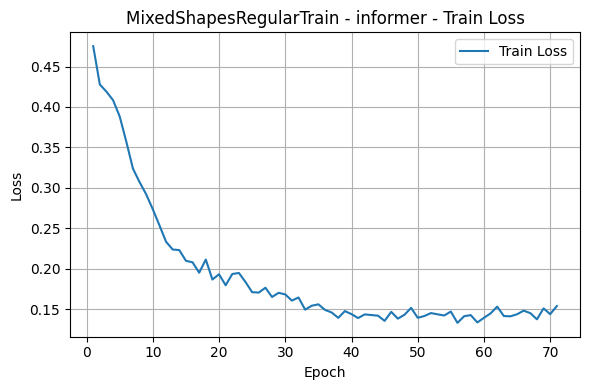

[MixedShapesRegularTrain | informer] TEST AUC=0.9583, TEST ACC=0.8095, n_samples=2425


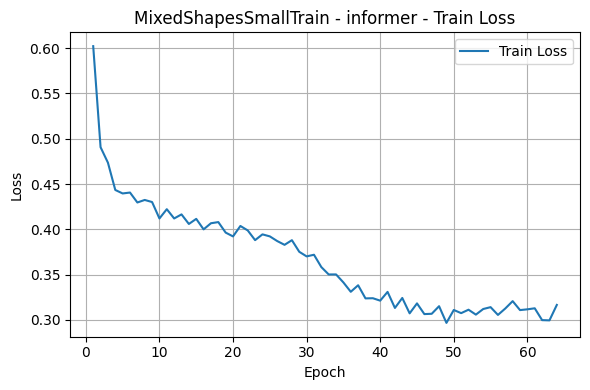

[MixedShapesSmallTrain | informer] TEST AUC=0.8585, TEST ACC=0.5798, n_samples=2425


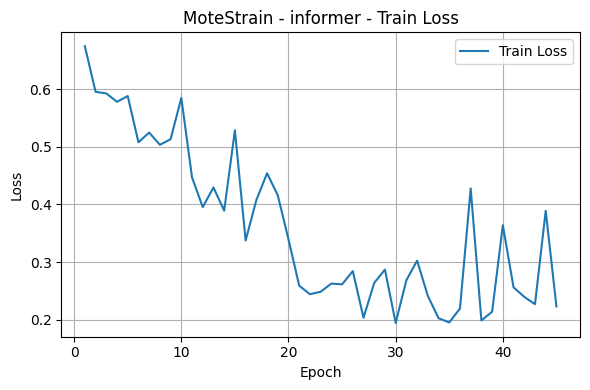

[MoteStrain | informer] TEST AUC=0.8800, TEST ACC=1.0000, n_samples=1238


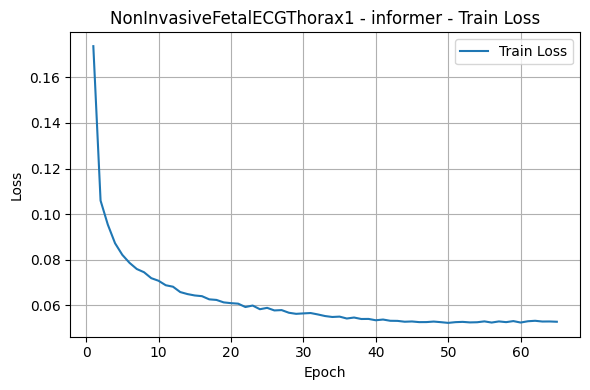

[NonInvasiveFetalECGThorax1 | informer] TEST AUC=0.9708, TEST ACC=0.4616, n_samples=1965


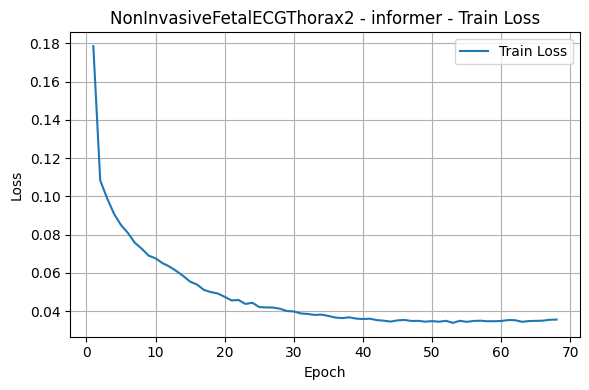

[NonInvasiveFetalECGThorax2 | informer] TEST AUC=0.9880, TEST ACC=0.7023, n_samples=1965


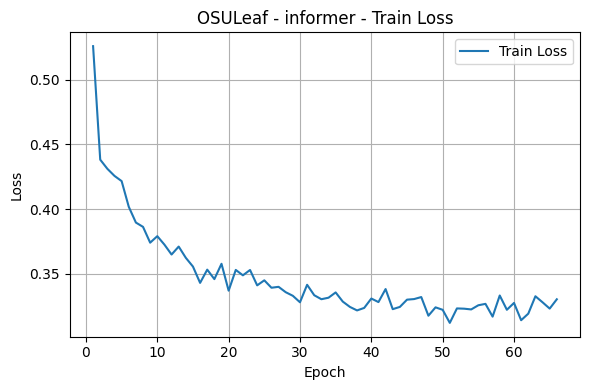

[OSULeaf | informer] TEST AUC=0.7633, TEST ACC=0.3926, n_samples=242


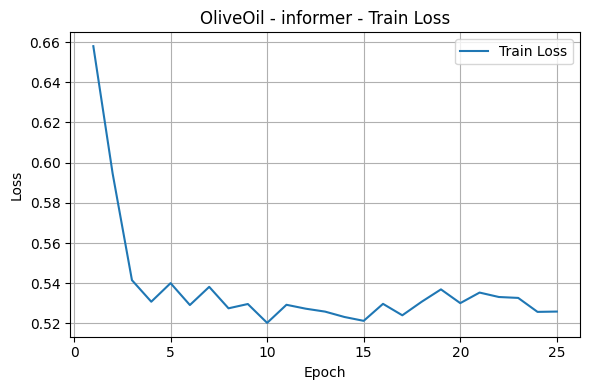

[OliveOil | informer] TEST AUC=0.5969, TEST ACC=0.4000, n_samples=30


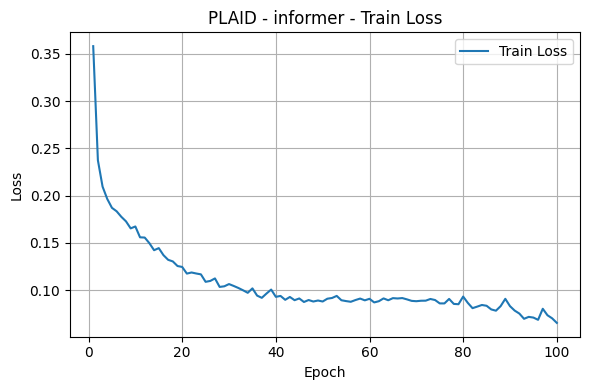

[PLAID | informer] TEST AUC=0.9633, TEST ACC=0.7598, n_samples=537


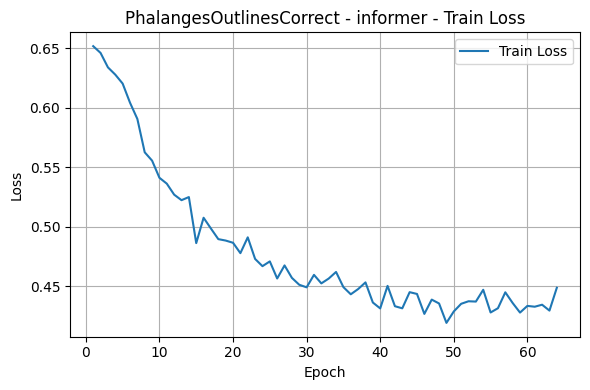

[PhalangesOutlinesCorrect | informer] TEST AUC=0.8669, TEST ACC=1.0000, n_samples=596


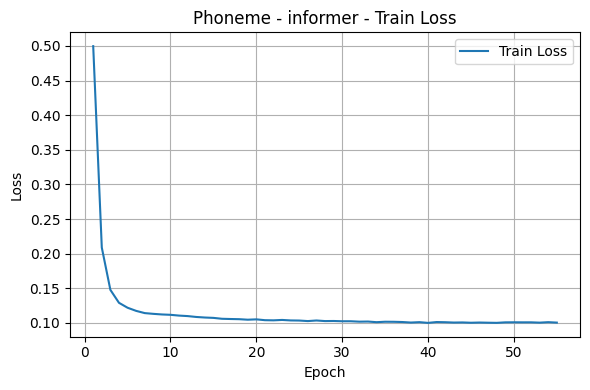

[Phoneme | informer] TEST AUC=0.6291, TEST ACC=0.1716, n_samples=1894


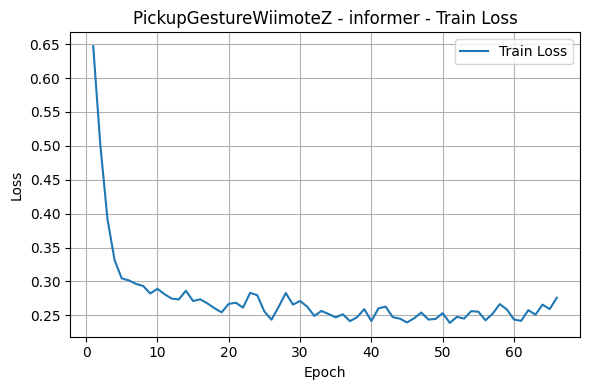

[PickupGestureWiimoteZ | informer] TEST AUC=0.8089, TEST ACC=0.3800, n_samples=50


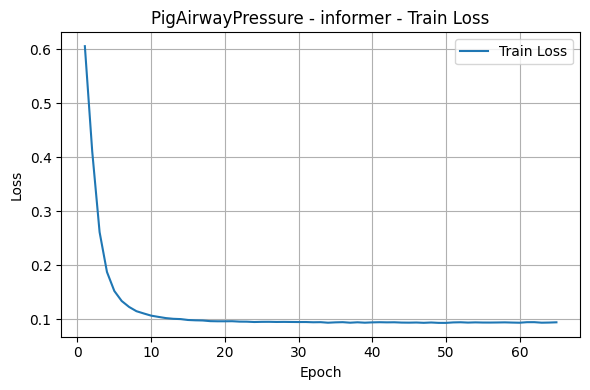

[PigAirwayPressure | informer] TEST AUC=0.4905, TEST ACC=0.0337, n_samples=208


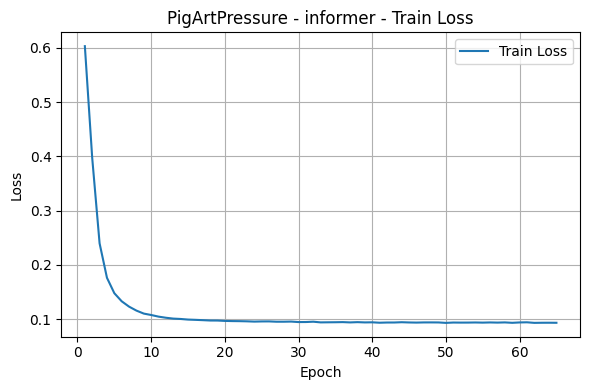

[PigArtPressure | informer] TEST AUC=0.6358, TEST ACC=0.0529, n_samples=208


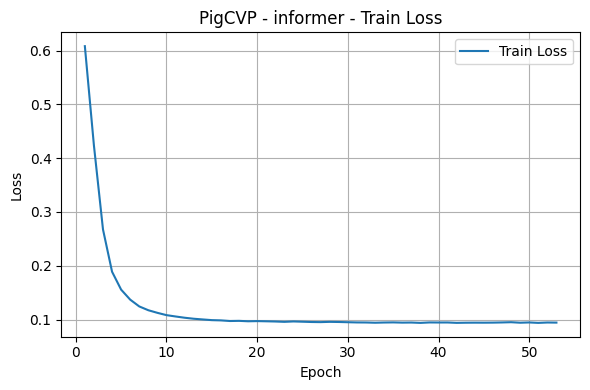

[PigCVP | informer] TEST AUC=0.6290, TEST ACC=0.0385, n_samples=208


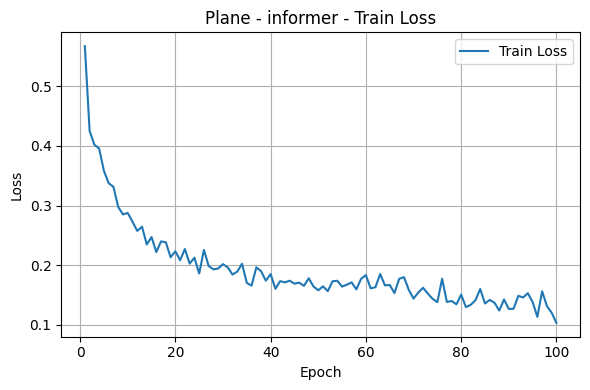

[Plane | informer] TEST AUC=0.9682, TEST ACC=0.5905, n_samples=105


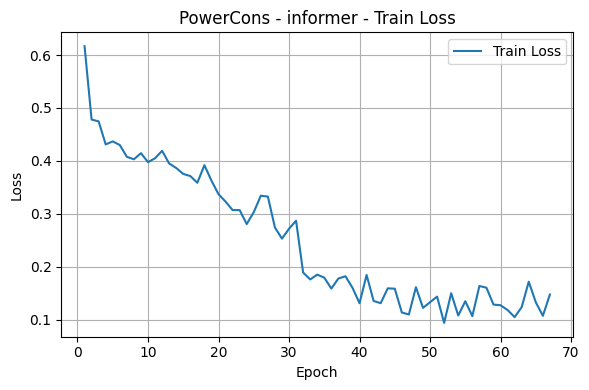

[PowerCons | informer] TEST AUC=0.9888, TEST ACC=1.0000, n_samples=180


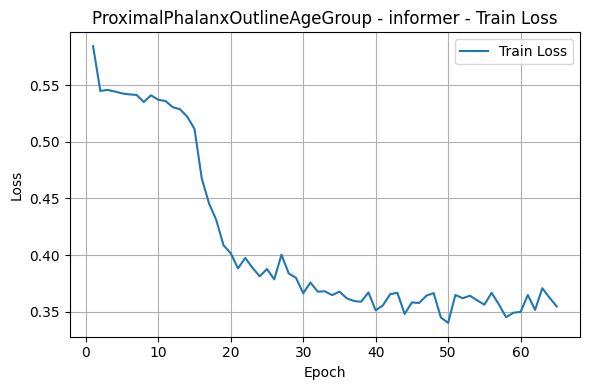

[ProximalPhalanxOutlineAgeGroup | informer] TEST AUC=0.8466, TEST ACC=0.7830, n_samples=106


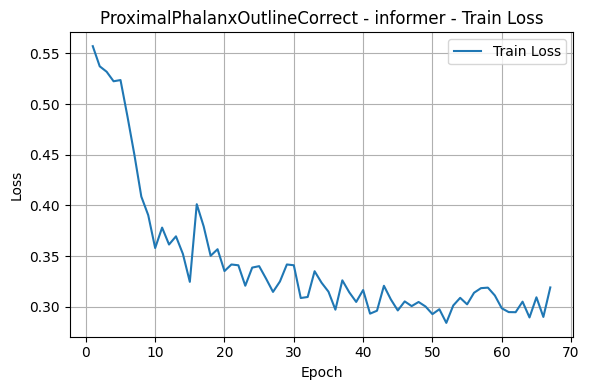

[ProximalPhalanxOutlineCorrect | informer] TEST AUC=0.9654, TEST ACC=1.0000, n_samples=121


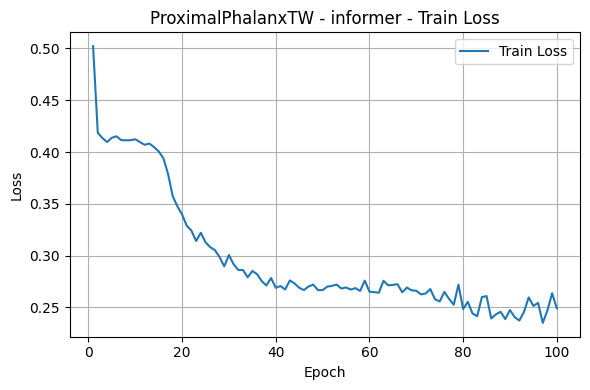

[ProximalPhalanxTW | informer] TEST AUC=0.9119, TEST ACC=0.6992, n_samples=123


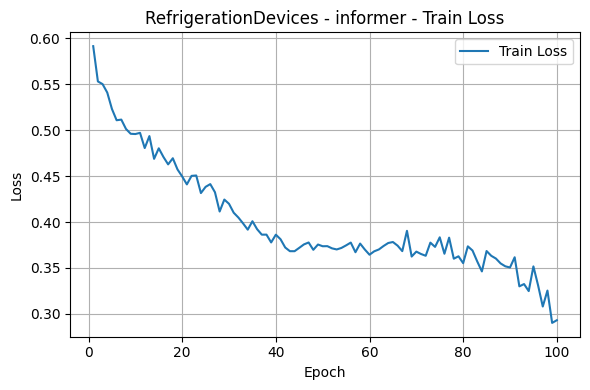

[RefrigerationDevices | informer] TEST AUC=0.7514, TEST ACC=0.5907, n_samples=364


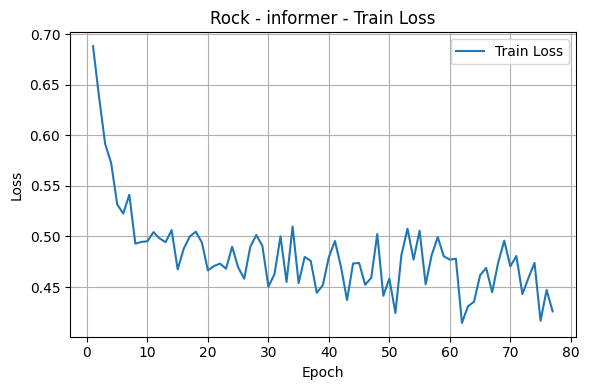

[Rock | informer] TEST AUC=0.7438, TEST ACC=0.5400, n_samples=50


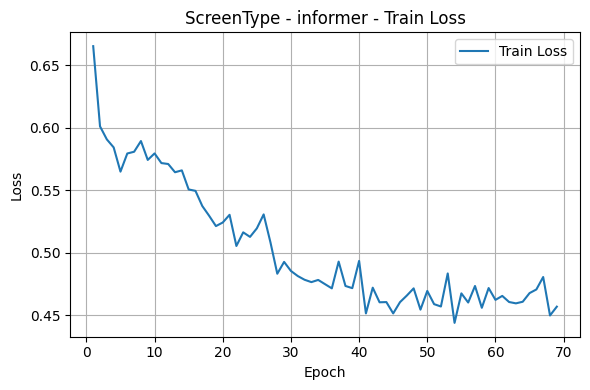

[ScreenType | informer] TEST AUC=0.6437, TEST ACC=0.5167, n_samples=60


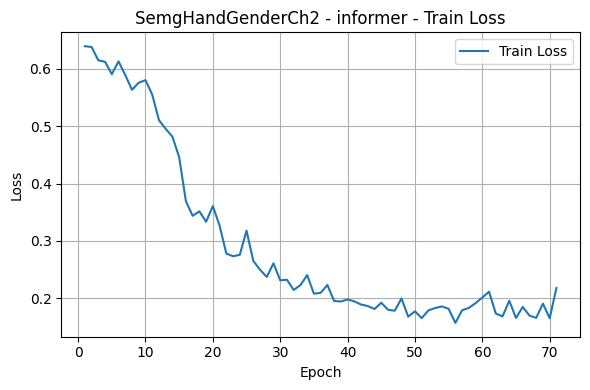

[SemgHandGenderCh2 | informer] TEST AUC=0.9191, TEST ACC=1.0000, n_samples=600


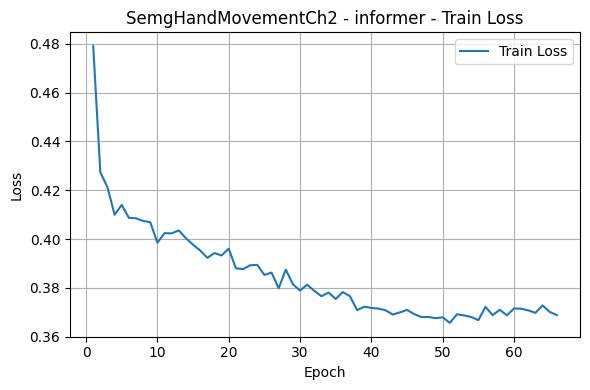

[SemgHandMovementCh2 | informer] TEST AUC=0.7407, TEST ACC=0.3733, n_samples=450


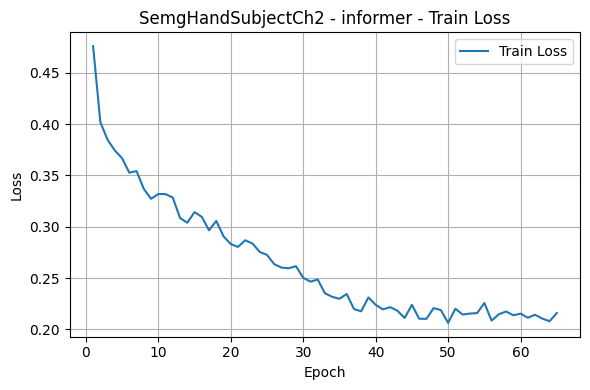

[SemgHandSubjectCh2 | informer] TEST AUC=0.9115, TEST ACC=0.7022, n_samples=450


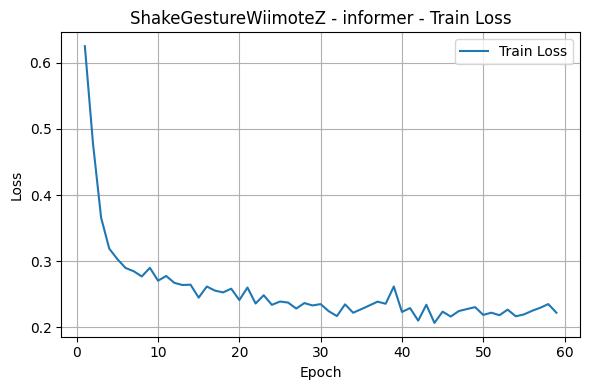

[ShakeGestureWiimoteZ | informer] TEST AUC=0.9031, TEST ACC=0.6400, n_samples=50


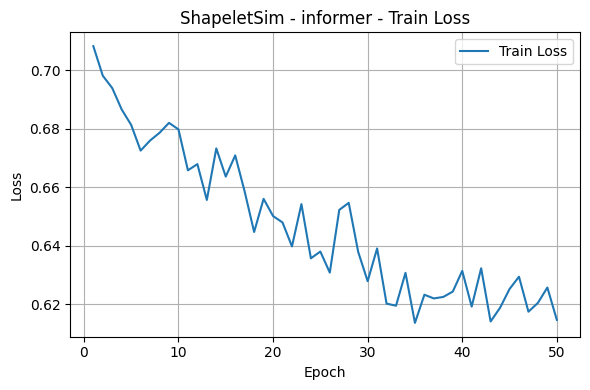

[ShapeletSim | informer] TEST AUC=0.8840, TEST ACC=1.0000, n_samples=180


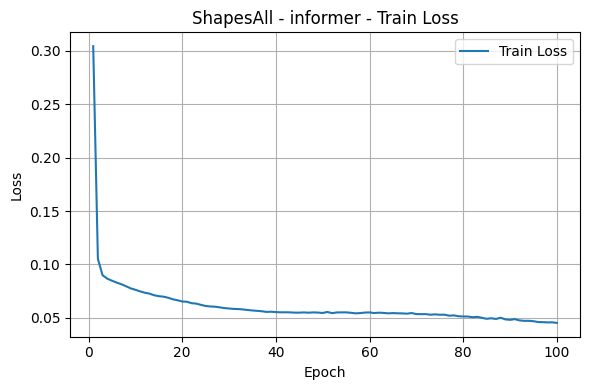

[ShapesAll | informer] TEST AUC=0.9359, TEST ACC=0.3867, n_samples=600


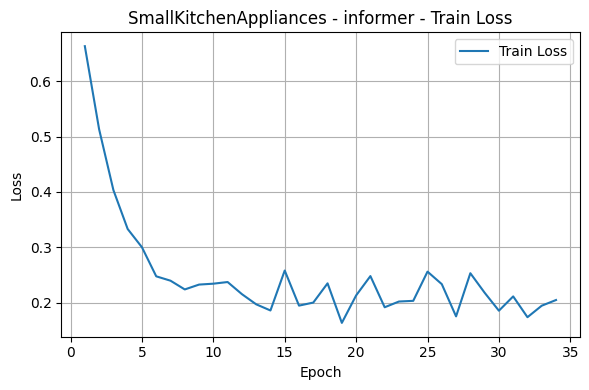

[SmallKitchenAppliances | informer] TEST AUC=0.6754, TEST ACC=0.8246, n_samples=57


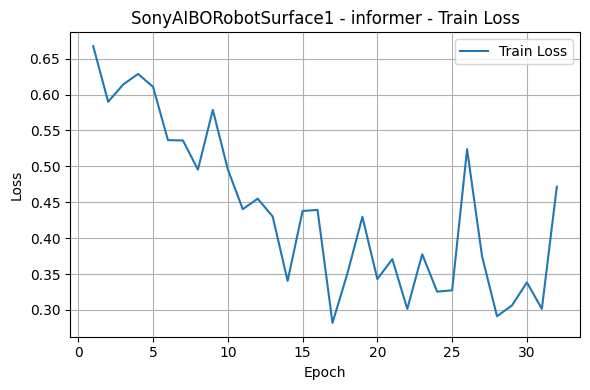

[SonyAIBORobotSurface1 | informer] TEST AUC=0.9797, TEST ACC=1.0000, n_samples=599


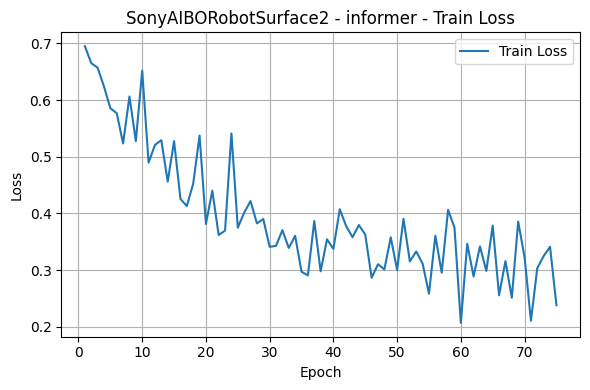

[SonyAIBORobotSurface2 | informer] TEST AUC=0.9016, TEST ACC=1.0000, n_samples=945


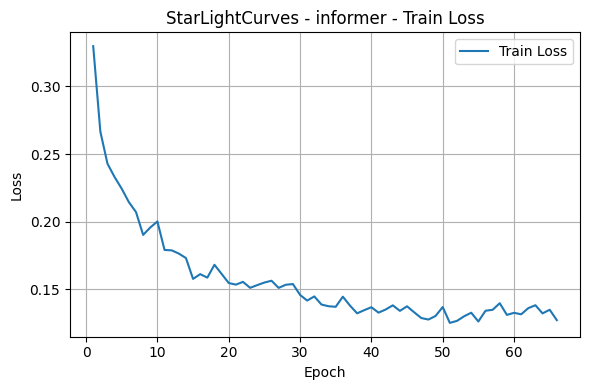

[StarLightCurves | informer] TEST AUC=0.9787, TEST ACC=0.9208, n_samples=8236


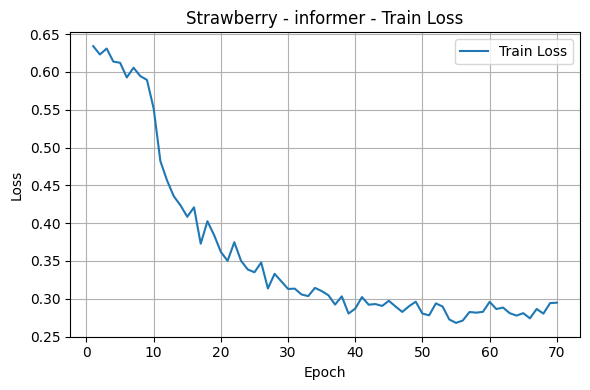

[Strawberry | informer] TEST AUC=0.9586, TEST ACC=1.0000, n_samples=370


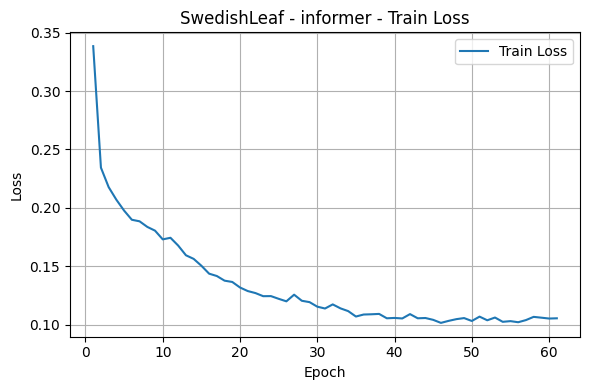

[SwedishLeaf | informer] TEST AUC=0.9723, TEST ACC=0.7136, n_samples=625


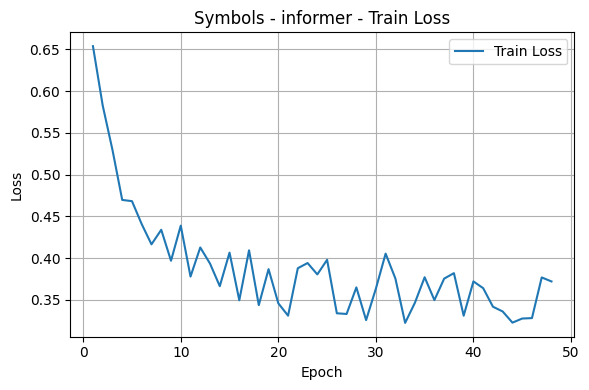

[Symbols | informer] TEST AUC=0.7744, TEST ACC=0.3025, n_samples=995


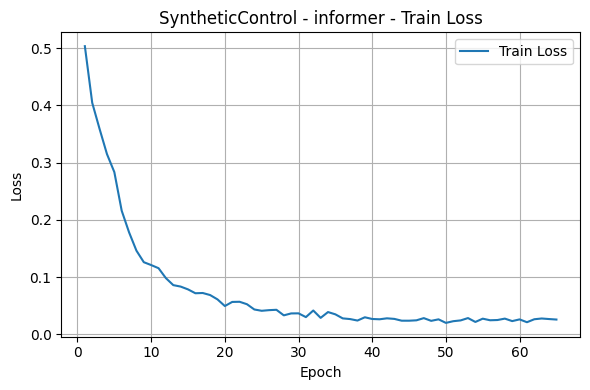

[SyntheticControl | informer] TEST AUC=0.9990, TEST ACC=0.9767, n_samples=300


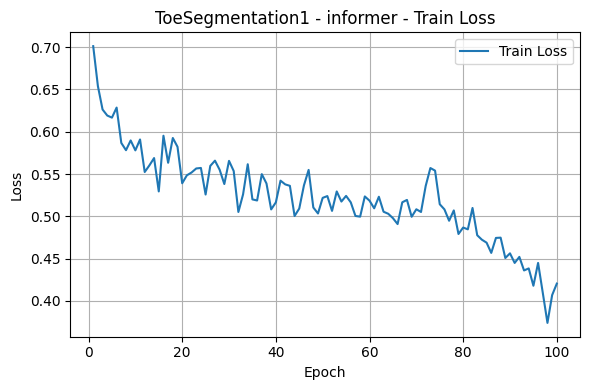

[ToeSegmentation1 | informer] TEST AUC=0.8787, TEST ACC=1.0000, n_samples=228


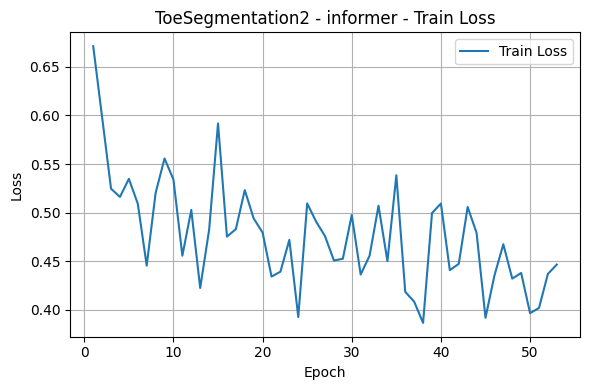

[ToeSegmentation2 | informer] TEST AUC=0.6128, TEST ACC=1.0000, n_samples=130


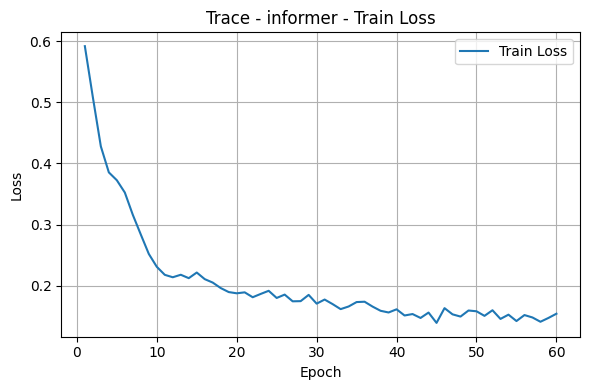

[Trace | informer] TEST AUC=0.9932, TEST ACC=0.9800, n_samples=100


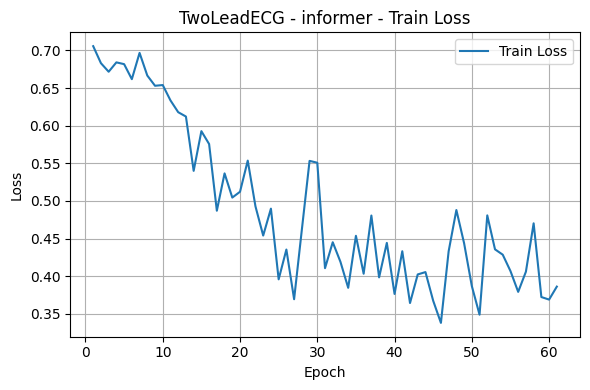

[TwoLeadECG | informer] TEST AUC=0.9225, TEST ACC=1.0000, n_samples=1139


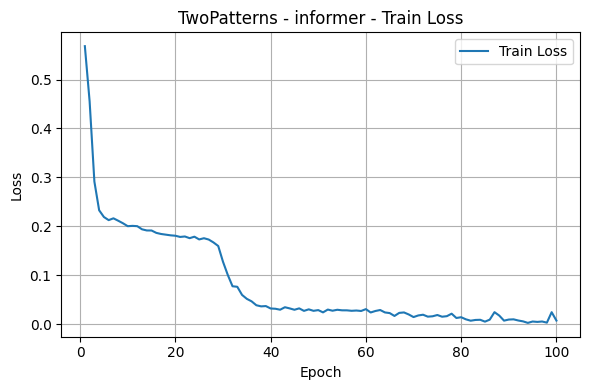

[TwoPatterns | informer] TEST AUC=1.0000, TEST ACC=0.9972, n_samples=3957


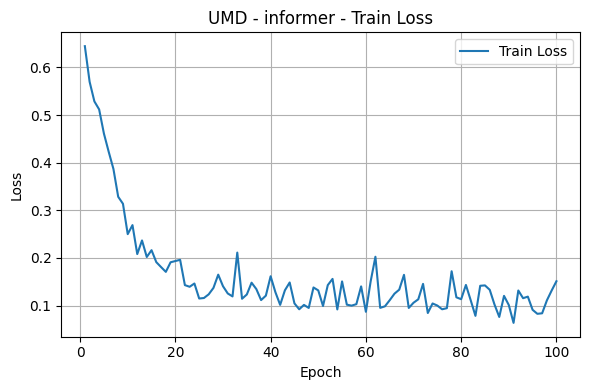

[UMD | informer] TEST AUC=0.9727, TEST ACC=0.8958, n_samples=144


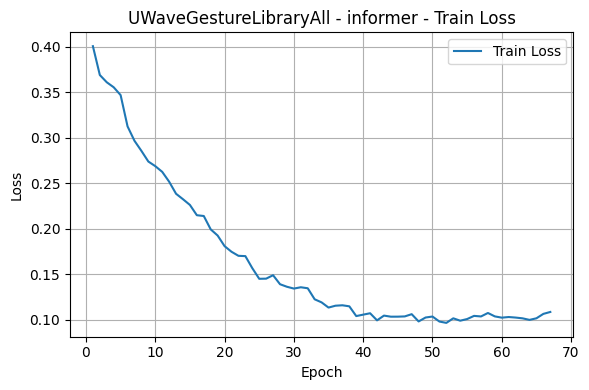

[UWaveGestureLibraryAll | informer] TEST AUC=0.9791, TEST ACC=0.8452, n_samples=3579


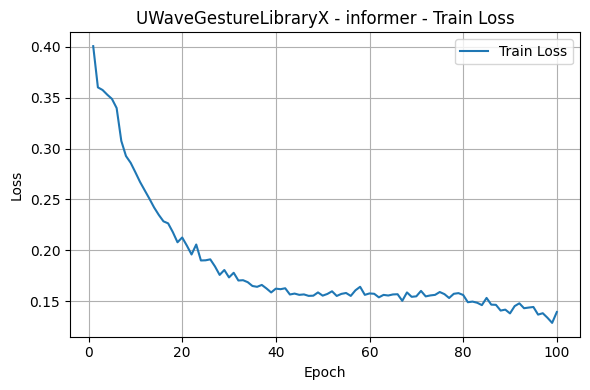

[UWaveGestureLibraryX | informer] TEST AUC=0.9322, TEST ACC=0.7258, n_samples=3238


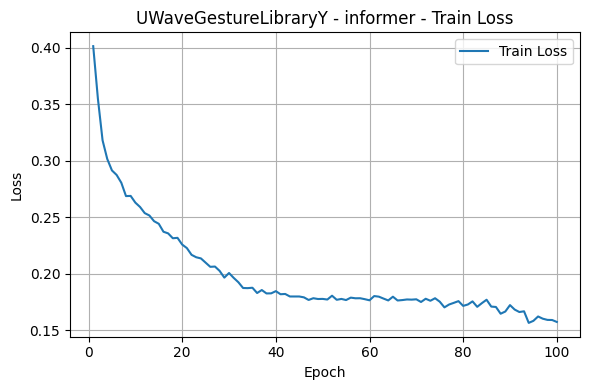

[UWaveGestureLibraryY | informer] TEST AUC=0.9312, TEST ACC=0.6248, n_samples=3206


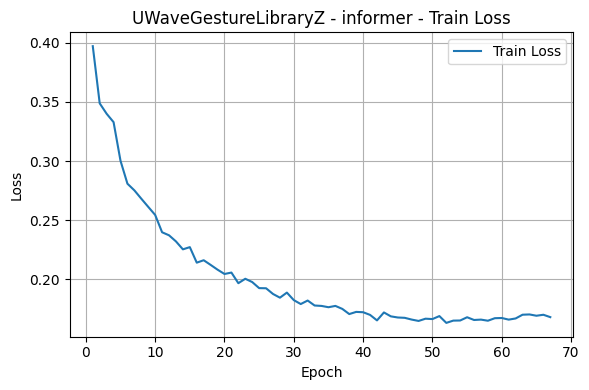

[UWaveGestureLibraryZ | informer] TEST AUC=0.9277, TEST ACC=0.6702, n_samples=3220


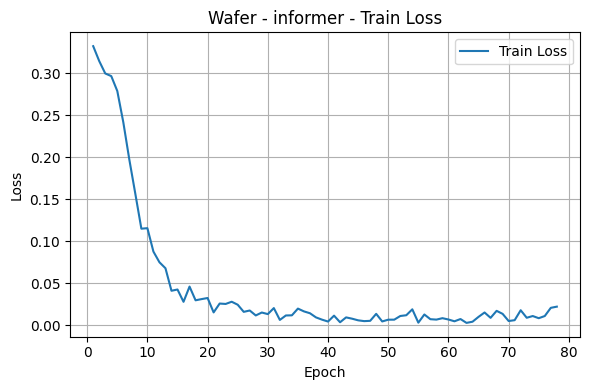

[Wafer | informer] TEST AUC=0.9633, TEST ACC=1.0000, n_samples=5935


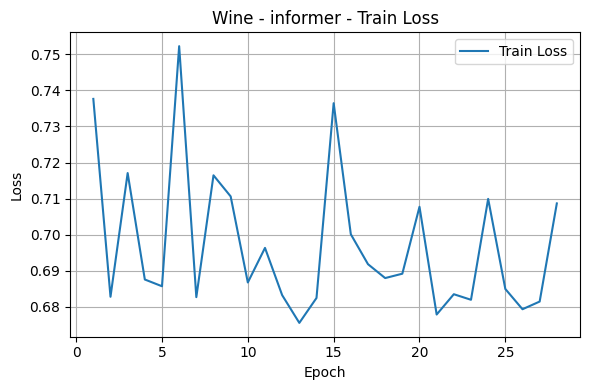

[Wine | informer] TEST AUC=0.5748, TEST ACC=1.0000, n_samples=54


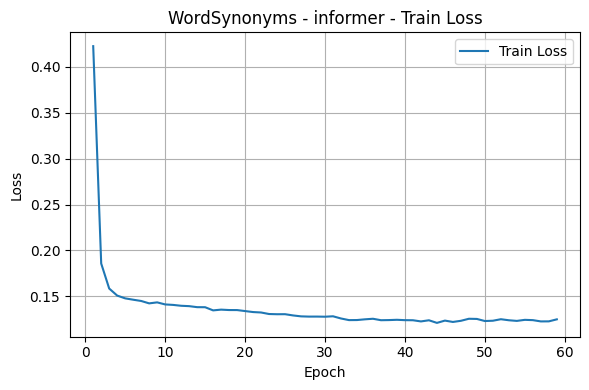

[WordSynonyms | informer] TEST AUC=0.7560, TEST ACC=0.3025, n_samples=638


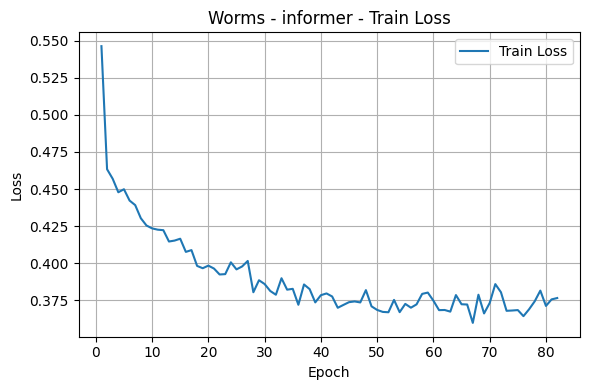

[Worms | informer] TEST AUC=0.7434, TEST ACC=0.4416, n_samples=77


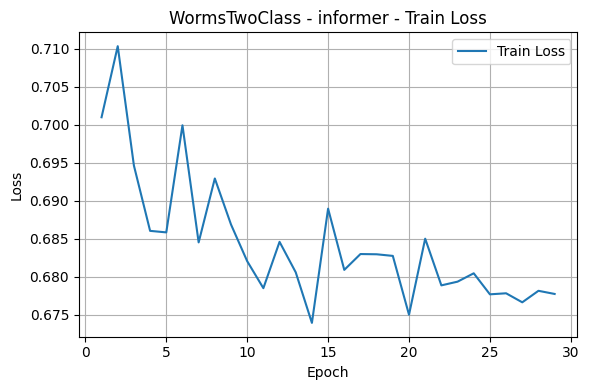

[WormsTwoClass | informer] TEST AUC=0.4621, TEST ACC=1.0000, n_samples=77


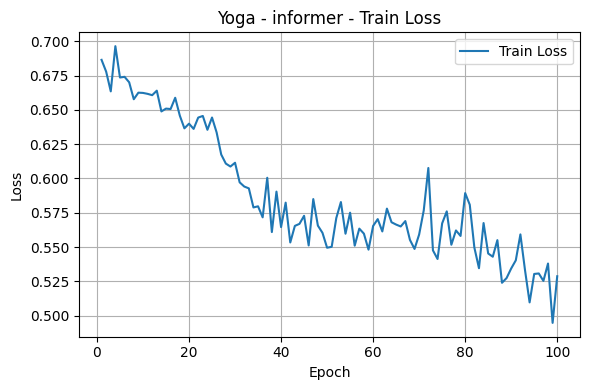

[Yoga | informer] TEST AUC=0.8025, TEST ACC=1.0000, n_samples=3000

========== Summary (OFFICIAL TEST) ==========
                       dataset  test_auc  test_acc  n_samples
                         ACSF1  0.964556  0.750000        100
                         Adiac  0.944350  0.342711        391
            AllGestureWiimoteX  0.823817  0.365639        681
            AllGestureWiimoteY  0.873025  0.477519        645
            AllGestureWiimoteZ  0.798604  0.306569        685
                     ArrowHead  0.746150  0.502857        175
                           BME  0.779400  0.566667        150
                          Beef  0.718056  0.433333         30
                     BeetleFly  0.720000  1.000000         20
                   BirdChicken  0.940000  1.000000         20
                           CBF  0.846973  0.630000        900
                           Car  0.790707  0.533333         60
                     Chinatown  0.992908  1.000000        343
         ChlorineC

In [16]:
# 只跑 Informer（单塔）
_ = run_all_datasets(
    root=ROOT,
    device='cuda:0',
    batch_size=8,
    num_epochs=100,
    lr=1e-4,
    cap_len=None,
    verbose=False,
    plot_curves=True,
    patience=15,
    backbone='informer'   # ← 关键：只需把骨干设为 informer
)
